# Plots and Tables for the DOE Analyses

### National Renewable Energy Laboratory

#### Rob Hammond
##### 10 September 2020

In [1]:
import os
import re
from copy import deepcopy

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

from wombat.simulation import WombatEnvironment
from wombat.windfarm import Windfarm
from wombat.simulation.repairs import RepairManager

%matplotlib inline

pd.set_option("display.max_columns", 1000)
pd.set_option("display.max_rows", 1000)

## Quick refresh on running a simulation and saving the outputs

In [2]:
# simulation_name = "offshore_base_3_month_summer"
# weather = "vineyard_wind_weather_1998_2017.csv"
# layout = "dudgeon_array.csv"
# crane = "offshore_jackup_3_month_summer.yaml"
# crew_transfer = "offshore_ctv.yaml"
# cable = "cable_vessel_3_month_summer.yaml"
# library_path = "/Users/rhammond/Documents/GitHub/wombat/library/"

# #### THE SETUP ####
# env = WombatEnvironment(library_path, weather, simulation_name=simulation_name, workday_start=8, workday_end=18)
# manager = RepairManager(env)
# windfarm = Windfarm(env, layout, manager)

# crn = Equipment(env, windfarm, manager, crane)
# ctv = Equipment(env,windfarm, manager, crew_transfer)
# cab = Equipment(env, windfarm, manager, cable)

# #### RUN THE SCENARIO ####
# env.run()

# events = env.create_events_log_dataframe()
# operations = env.create_operations_log_dataframe()

# events_save_path = os.path.join(library_path, "outputs", "csv_logs", f"{simulation_name}_events.csv")
# events.sort_values("env_time").to_csv(events_save_path, index_label="datetime")

# turbine_columns = [col for col in operations if col not in ("env_datetime", "env_time", "DOW_OSS")]
# column_order = ["env_datetime", "env_time", "windfarm", "DOW_OSS"] + turbine_columns

# operations["windfarm"] = operations["DOW_OSS"].values * np.mean(operations[turbine_columns].values, axis=1)
# operations = operations[column_order]

# operations_save_path = os.path.join(library_path, "outputs", "csv_logs", f"{simulation_name}_operations.csv")
# operations.sort_values("env_time").to_csv(operations_save_path, index_label="datetime")

## Helper Functions

In [3]:
def equipment_labor_cost_breakdown(events_df, equipment, total_mw, years):
    events_df = (
        events_df[
            events_df.agent.isin(equipment)
            & events_df.action.isin(["delay", "repair", "maintenance"])
            & ~events_df.reason.isin(["Work is complete"])
        ]
        .groupby(["action", "reason"])
        .sum()
    )

    non_hours = [
        ("delay", "Not in working hours."),
        ("delay", "Work shift has ended. Waiting for next shift to start"),
    ]
    events_df.loc[("delay", "Not in Shift"), :] = events_df.loc[non_hours].sum(axis=0)
    events_df = events_df.drop(index=non_hours)

    events_df.loc[("working", "working"), :] = events_df.loc["maintenance"].sum(
        axis=0
    ) + events_df.loc["repair"].sum(axis=0)
    events_df = events_df.drop(
        index=[el for el in events_df.index if el[0] in ("repair", "maintenance")]
    )

    events_df = events_df.loc[:, ["total_cost"]]
    events_df = events_df.droplevel(0)

    events_df = events_df / total_mw / years

    events_df = events_df.rename(
        index={
            "No requests": "No Requests",
            "weather delay": "Weather Delay",
            "Not in Shift": "Outside Working Hours",
            "working": "Working",
        }
    )

    return events_df


def make_label_multi_lines(text: str, longest_line_length: int = 12) -> str:
    new_text = ""
    while len(text) > longest_line_length:
        space_ix = np.array([m.start() for m in re.finditer(" ", text)])
        if space_ix.size == 0:
            break
        ix = np.argmin(np.abs(space_ix - longest_line_length))
        new_text = f"{new_text}\n{text[: space_ix[ix]]}"
        text = text[space_ix[ix] + 1 :]

    return f"{new_text}\n{text}".strip()

## Setting up the Data

In [4]:
years = range(1998, 2018)
months = range(1, 13)
library_path = "/Users/rhammond/Documents/GitHub/wombat/library/"

month_map = {
    1: "Jan",
    2: "Feb",
    3: "Mar",
    4: "Apr",
    5: "May",
    6: "Jun",
    7: "Jul",
    8: "Aug",
    9: "Sep",
    10: "Oct",
    11: "Nov",
    12: "Dec",
}

offshore_total_mw = 67 * 10
onshore_total_mw = 67 * 3
cost_columns = ["total_labor_cost", "materials_cost", "equipment_cost", "total_cost"]
offshore_equipment = ["Jack-up Vessel", "Cable Laying Vessel", "Windcat MK III"]
onshore_equipment = ["Crawler Crane", "Onshore Cabling", "Truck"]

In [5]:
cost_format_dict = {
    "materials_cost": {
        "name": "Materials",
        "color": "#027A3E",
    },
    "hourly_labor_cost": {
        "name": "Hourly Labor",
        "color": "#ffffff",
    },
    "salary_labor_cost": {
        "name": "Salaried Labor",
        "color": "#ffffff",
    },
    "equipment_cost": {
        "name": "Equipment",
        "color": "#ffffff",
    },
    "total_labor_cost": {
        "name": "Total Labor",
        "color": "#049BD6",
    },
    "total_cost": {
        "name": "Total",
        "color": "#035068",
    },
    "Jack-up Vessel": {
        "name": "Crane",
        "color": "#FBD876",
    },
    "Crawler Crane": {
        "name": "Crane",
        "color": "#FBD876",
    },
    "Truck": {
        "name": "Crew Transfer",
        "color": "#83C554",
    },
    "Windcat MK III": {
        "name": "Crew Transfer",
        "color": "#83C554",
    },
    "Onshore Cabling": {
        "name": "Cable",
        "color": "#E37225",
    },
    "Cable Laying Vessel": {
        "name": "Cable",
        "color": "#E37225",
    },
}

In [6]:
scenarios = {
    #### OFFSHORE ####
    "offshore_base_3_month_summer": [
        "vineyard_wind_weather_1998_2017.csv",
        "offshore_dudgeon_array.csv",
        "offshore_jackup_3_month_summer.yaml",
        "offshore_ctv.yaml",
        "cable_vessel_3_month_summer.yaml",
    ],
    "offshore_base_no_weather_3_month_summer": [
        "vineyard_wind_weather_1998_2017_no_wind_wave.csv",
        "offshore_dudgeon_array.csv",
        "offshore_jackup_3_month_summer.yaml",
        "offshore_ctv.yaml",
        "cable_vessel_3_month_summer.yaml",
    ],
    "offshore_double_3_month_summer": [
        "vineyard_wind_weather_1998_2017.csv",
        "offshore_dudgeon_array_double.csv",
        "offshore_jackup_3_month_summer.yaml",
        "offshore_ctv.yaml",
        "cable_vessel_3_month_summer.yaml",
    ],
    "offshore_12_month": [
        "vineyard_wind_weather_1998_2017.csv",
        "offshore_dudgeon_array.csv",
        "offshore_jackup_12_month.yaml",
        "offshore_ctv.yaml",
        "cable_vessel_12_month.yaml",
    ],
    "offshore_0_month": [
        "vineyard_wind_weather_1998_2017.csv",
        "offshore_dudgeon_array.csv",
        None,
        None,
        None,
    ],
    #### ONSHORE ####
    "onshore_base_3_month_summer": [
        "sweetwater_weather_1998_2017.csv",
        "onshore_dudgeon_array.csv",
        "onshore_crawler_3_month_summer.yaml",
        "onshore_onsite.yaml",
        "onshore_cable_3_month_summer.yaml",
    ],
    "onshore_base_no_weather_3_month_summer": [
        "sweetwater_weather_1998_2017.csv",
        "onshore_dudgeon_array.csv",
        "onshore_crawler_3_month_summer.yaml",
        "onshore_onsite.yaml",
        "onshore_cable_3_month_summer.yaml",
    ],
    "onshore_double_3_month_summer": [
        "sweetwater_weather_1998_2017.csv",
        "onshore_dudgeon_array_double.csv",
        "onshore_crawler_3_month_summer.yaml",
        "onshore_onsite.yaml",
        "onshore_cable_3_month_summer.yaml",
    ],
    "onshore_12_month": [
        "sweetwater_weather_1998_2017.csv",
        "onshore_dudgeon_array.csv",
        "onshore_crawler_12_month.yaml",
        "onshore_onsite.yaml",
        "onshore_cable_12_month.yaml",
    ],
    "onshore_0_month": [
        "sweetwater_weather_1998_2017.csv",
        "onshore_dudgeon_array.csv",
        None,
        None,
        None,
    ],
}

In [7]:
format_categories = [
    dict(
        name="Base Scenario",
        color="#035068",
        marker_color="#035068",
        linestyle="-",
        marker="o",
    ),
    dict(
        name="No Weather",
        color="#818386",
        marker_color="#FBD876",
        linestyle="dashed",
        marker="P",
    ),
    dict(
        name="Change in MTBF",
        color="#83C554",
        marker_color="#83C554",
        linestyle="-",
        alpha=0.6,
        marker="o",
    ),
    dict(
        name="Change in Visit Length",
        color="#818386",
        marker_color="#E37225",
        linestyle="-",
        marker="d",
    ),
    #     dict(name="Change in Season", color="#818386", marker_color="#027A3E", linestyle="dotted", marker="s"),
]

format_dict = {
    #### OFFSHORE ###
    "offshore_base_3_month_summer": {
        "name": "Base (3 Month Summer Visit)",
        "format": dict(
            color="#035068", marker_color="#035068", linestyle="-", alpha=1, marker="o"
        ),
    },
    "offshore_base_no_weather_3_month_summer": {
        "name": "No Weather",
        "format": dict(
            color="#818386",
            marker_color="#FBD876",
            linestyle="dashed",
            alpha=0.6,
            marker="P",
        ),
    },
    "offshore_double_3_month_summer": {
        "name": "Doubled MTBF",
        "format": dict(
            color="#83C554",
            marker_color="#83C554",
            linestyle="-",
            alpha=0.6,
            marker="o",
        ),
    },
    "offshore_12_month": {
        "name": "12 Month Visit",
        "format": dict(
            color="#818386",
            marker_color="#E37225",
            linestyle="-",
            alpha=0.6,
            marker="d",
        ),
    },
    "offshore_0_month": {
        "name": "No Visit",
        "format": dict(
            color="#818386",
            marker_color="#027A3E",
            linestyle="-",
            alpha=0.6,
            marker="s",
        ),
    },
    #### ONSHORE ####
    "onshore_base_3_month_summer": {
        "name": "Base (3 Month Summer Visit)",
        "format": dict(
            color="#035068", marker_color="#035068", linestyle="-", alpha=1, marker="o"
        ),
    },
    "onshore_base_no_weather_3_month_summer": {
        "name": "No Weather",
        "format": dict(
            color="#818386",
            marker_color="#FBD876",
            linestyle="dashed",
            alpha=0.6,
            marker="P",
        ),
    },
    "onshore_double_3_month_summer": {
        "name": "Doubled MTBF",
        "format": dict(
            color="#83C554",
            marker_color="#83C554",
            linestyle="-",
            alpha=0.6,
            marker="o",
        ),
    },
    "onshore_12_month": {
        "name": "12 Month Visit",
        "format": dict(
            color="#818386",
            marker_color="#E37225",
            linestyle="-",
            alpha=0.6,
            marker="d",
        ),
    },
    "onshore_0_month": {
        "name": "No Visit",
        "format": dict(
            color="#818386",
            marker_color="#027A3E",
            linestyle="-",
            alpha=0.6,
            marker="s",
        ),
    },
}

In [8]:
print(f"{'Scenario':>42} | {'N Events':>9} | {'N Operations':>12}")
data_frames = {}
for simulation_name in scenarios:
    events_path = os.path.join(
        library_path, "outputs", "csv_logs", f"{simulation_name}_events.csv"
    )
    operations_path = os.path.join(
        library_path, "outputs", "csv_logs", f"{simulation_name}_operations.csv"
    )

    events = pd.read_csv(events_path)
    events.datetime = pd.to_datetime(events.datetime)
    events.env_datetime = pd.to_datetime(events.env_datetime)
    events["year"] = events.env_datetime.dt.year
    events["month"] = events.env_datetime.dt.month
    events.index = events.datetime
    events = events.drop(labels="datetime", axis=1)

    operations = pd.read_csv(operations_path)
    operations.datetime = pd.to_datetime(operations.datetime)
    operations.env_datetime = pd.to_datetime(operations.env_datetime)
    operations["year"] = operations.env_datetime.dt.year
    operations["month"] = operations.env_datetime.dt.month
    operations.index = operations.datetime
    operations = operations.drop(labels="datetime", axis=1)

    data_frames[simulation_name] = {
        "events": events,
        "operations": operations,
    }

    print(
        f"{simulation_name:>42} | {events.shape[0]:>9,.0f} | {operations.shape[0]:>12,.0f}"
    )

                                  Scenario |  N Events | N Operations
              offshore_base_3_month_summer |    35,749 |      175,320
   offshore_base_no_weather_3_month_summer |    34,293 |      175,320
            offshore_double_3_month_summer |    29,632 |      175,320
                         offshore_12_month |    65,404 |      175,320
                          offshore_0_month |     3,525 |      175,320
               onshore_base_3_month_summer |    29,051 |      175,320
    onshore_base_no_weather_3_month_summer |    28,809 |      175,320
             onshore_double_3_month_summer |    21,891 |      175,320
                          onshore_12_month |    45,757 |      175,320
                           onshore_0_month |     3,233 |      175,320


## Plot the Wind Farm

In [9]:
env = WombatEnvironment(
    library_path,
    "weather_short.csv",
    simulation_name="plot_only",
    workday_start=8,
    workday_end=18,
)
manager = RepairManager(env)
windfarm = Windfarm(env, "offshore_dudgeon_array.csv", manager)

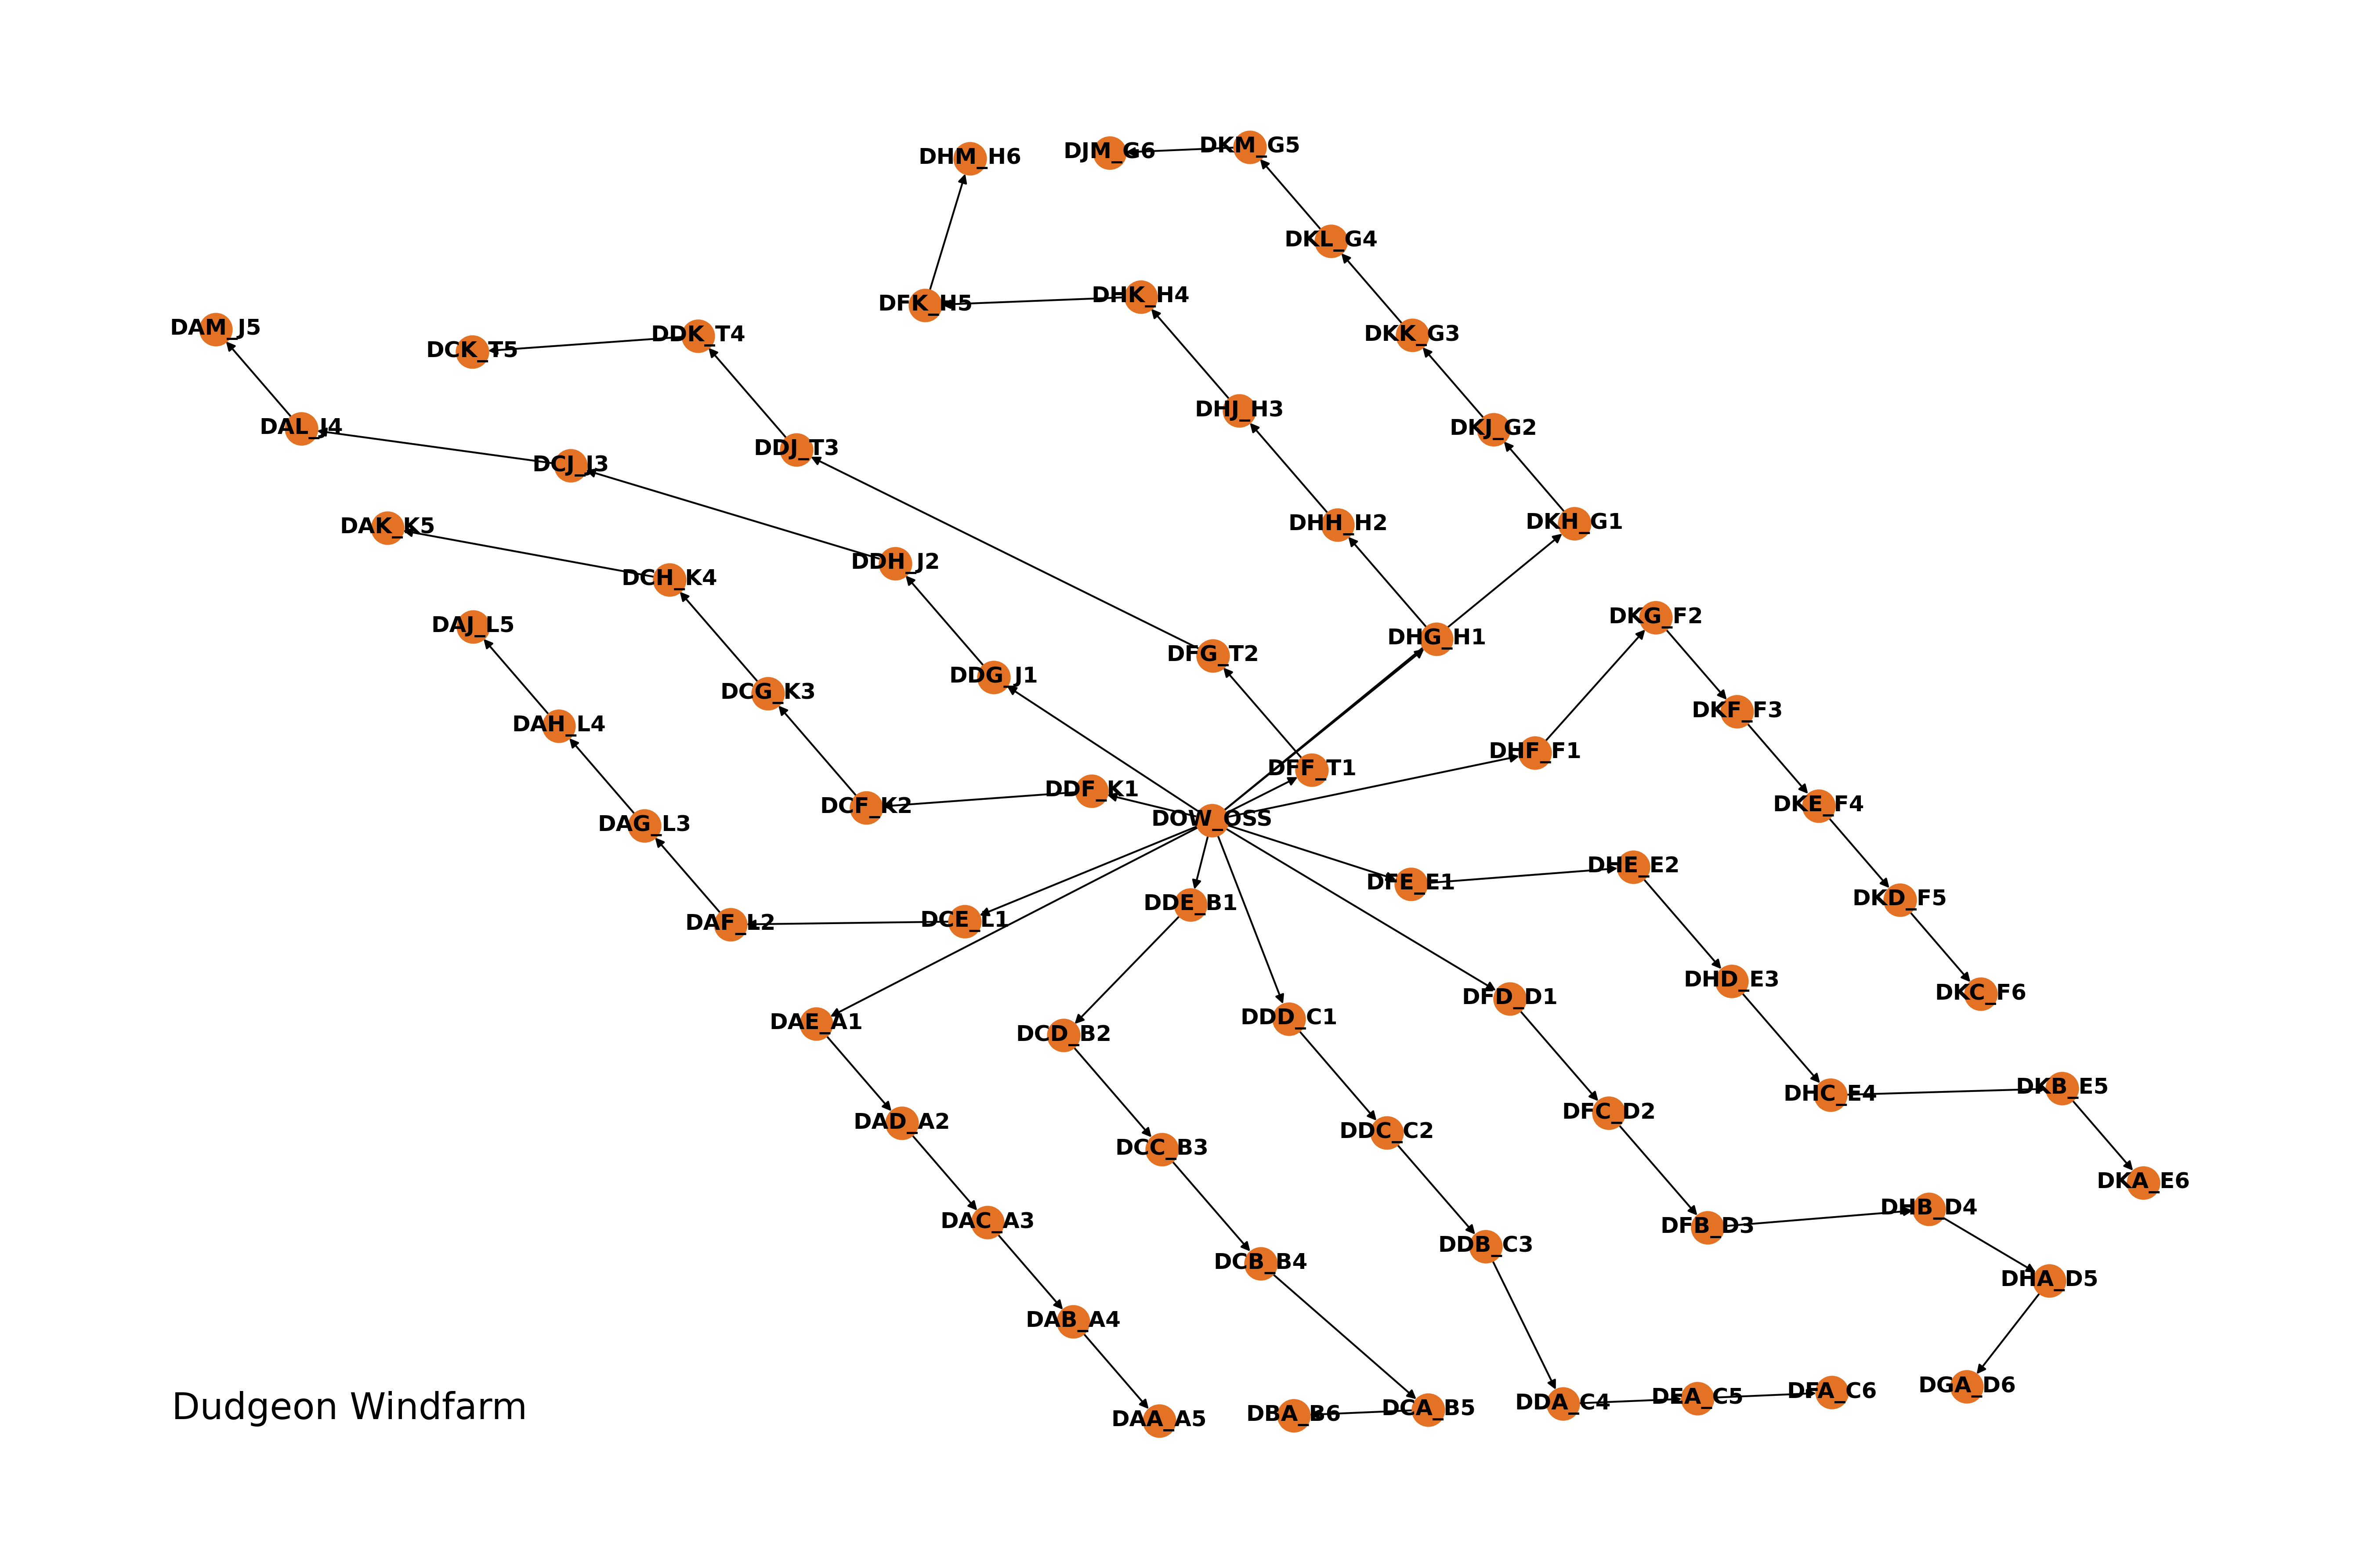

In [10]:
positions = {
    name: np.array([node["longitude"], node["latitude"]])
    for name, node in windfarm.graph.nodes(data=True)
}

fig = plt.figure(figsize=(18, 12), dpi=300)
ax = fig.add_subplot(111)

nx.draw(
    windfarm.graph,
    with_labels=True,
    font_weight="bold",
    pos=positions,
    ax=ax,
    node_color="#E37225",
)

ax.text(53.21, 1.32, "Dudgeon Windfarm", fontsize=20)

fig.tight_layout()
plt.savefig(
    os.path.join(
        library_path, "outputs/plots_and_tables/presentation/dudgeon_array_layout.png"
    ),
    bbox_inches="tight",
)
plt.savefig(
    os.path.join(
        library_path, "outputs/plots_and_tables/presentation/dudgeon_array_layout.svg"
    ),
    bbox_inches="tight",
)

In [11]:
def time_availability(turbine_availabiltiy: np.ndarray):
    """Computes the time-based availability of windfarm based on its turbines
    and substation operational ratios.
    """
    availability = turbine_availabiltiy > 0
    return availability.sum() / availability.size


def get_availability_data(operational_df: pd.DataFrame):
    """Computes the monthly time-based availability of a windfarm."""
    filter_cols = ["env_datetime", "env_time", "windfarm", "DOW_OSS", "year", "month"]
    turbine_cols = [col for col in operational_df.columns if col not in filter_cols]
    monthly_counts = operational_df.groupby(
        by=["year", "month"]
    ).count().windfarm * len(turbine_cols)

    substation_availability = operational_df["DOW_OSS"]
    turbine_availability = operational_df[turbine_cols]
    date_time = operational_df[["year", "month"]]
    hourly = (
        operational_df["DOW_OSS"].values.reshape((-1, 1))
        * operational_df[turbine_cols].values
    )
    monthly = [
        time_availability(hourly[(date_time.year == year) & (date_time.month == month)])
        for year, month in monthly_counts.index
    ]
    monthly_availability = pd.DataFrame(monthly_counts)
    monthly_availability.windfarm = monthly

    project_availability = time_availability(hourly)
    return monthly_availability, project_availability

## Offshore Availability

In [12]:
fig, ax = plt.subplots(figsize=(15, 7), dpi=300)

line_legend = []
for formatting in format_categories:
    line = mlines.Line2D(
        [],
        [],
        color=formatting["color"],
        linestyle=formatting["linestyle"],
        label=formatting["name"],
    )
    line_legend.append(line)

ax.plot(np.arange(241), np.repeat(0.92, 241), alpha=0.8, color="black")
ax.text(242, 0.92, "Combined Industry Average: 92%*", va="center")

for scenario in data_frames:
    if scenario.startswith("onshore"):
        continue

    operations = data_frames[scenario]["operations"]
    monthly_availability, project_availability = get_availability_data(operations)
    data_frames[scenario]["monthly_availability"] = monthly_availability
    data_frames[scenario]["project_availability"] = project_availability

    fmt = format_dict[scenario]["format"]
    ax.plot(
        range(monthly_availability.shape[0]),
        monthly_availability.windfarm.values,
        color=fmt["color"],
        linestyle=fmt["linestyle"],
        alpha=fmt["alpha"],
    )

    name = format_dict[scenario]["name"]
    text = f"{name}: {project_availability * 100:.1f}%"
    y = monthly_availability.loc[2017].loc[12].values[0]
    #     print(f"{name:>40}: {y*100:>4.2f}")
    if name == "Doubled MTBF":
        y *= 1.01
    elif name == "12 Month Visit":
        y *= 0.99
    ax.text(242, y, text, va="center")

xticks_major = [x * 12 for x in range(21)]
xticks_minor = list(range(0, 12 * 20, 3))
xlabels_major = [f"{year:>6}" for year in years]
xlabels_minor = ["Apr", "", "Oct"] + ["Apr", "", "Oct"] * 19
ax.set_xlabel("Simulation Time", fontsize=16)

ax.set_ylim(0, 1.1)
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_ylabel("Monthly Availability", fontsize=16)
ax.set_yticklabels([f"{y * 100:.0f}%" for y in ax.get_yticks()], fontsize=12)

ax.set_xlim(0, 300)
ax.set_xticks(xticks_major)
for t in ax.get_xticklabels():
    t.set_y(-0.05)
ax.set_xticks(xticks_minor, minor=True)
ax.set_xticklabels(xlabels_major, ha="left", fontsize=12)
ax.set_xticklabels(xlabels_minor, minor=True, rotation=90)

ax.set_title("Offshore Windfarm Availability", fontsize=18)
ax.legend(handles=line_legend, loc="lower left", fontsize=14)

plt.grid(axis="x", which="major")
plt.grid(alpha=0.2, which="minor")
ax.hlines(np.linspace(0, 1, 11), 0, 240, alpha=0.2, color="gray")

fig.tight_layout()
plt.savefig(
    os.path.join(
        library_path, "outputs/plots_and_tables/presentation/offshore_availability.png"
    ),
    bbox_to_inches="tight",
)
plt.savefig(
    os.path.join(
        library_path, "outputs/plots_and_tables/presentation/offshore_availability.svg"
    ),
    bbox_to_inches="tight",
)

## Onshore Availability

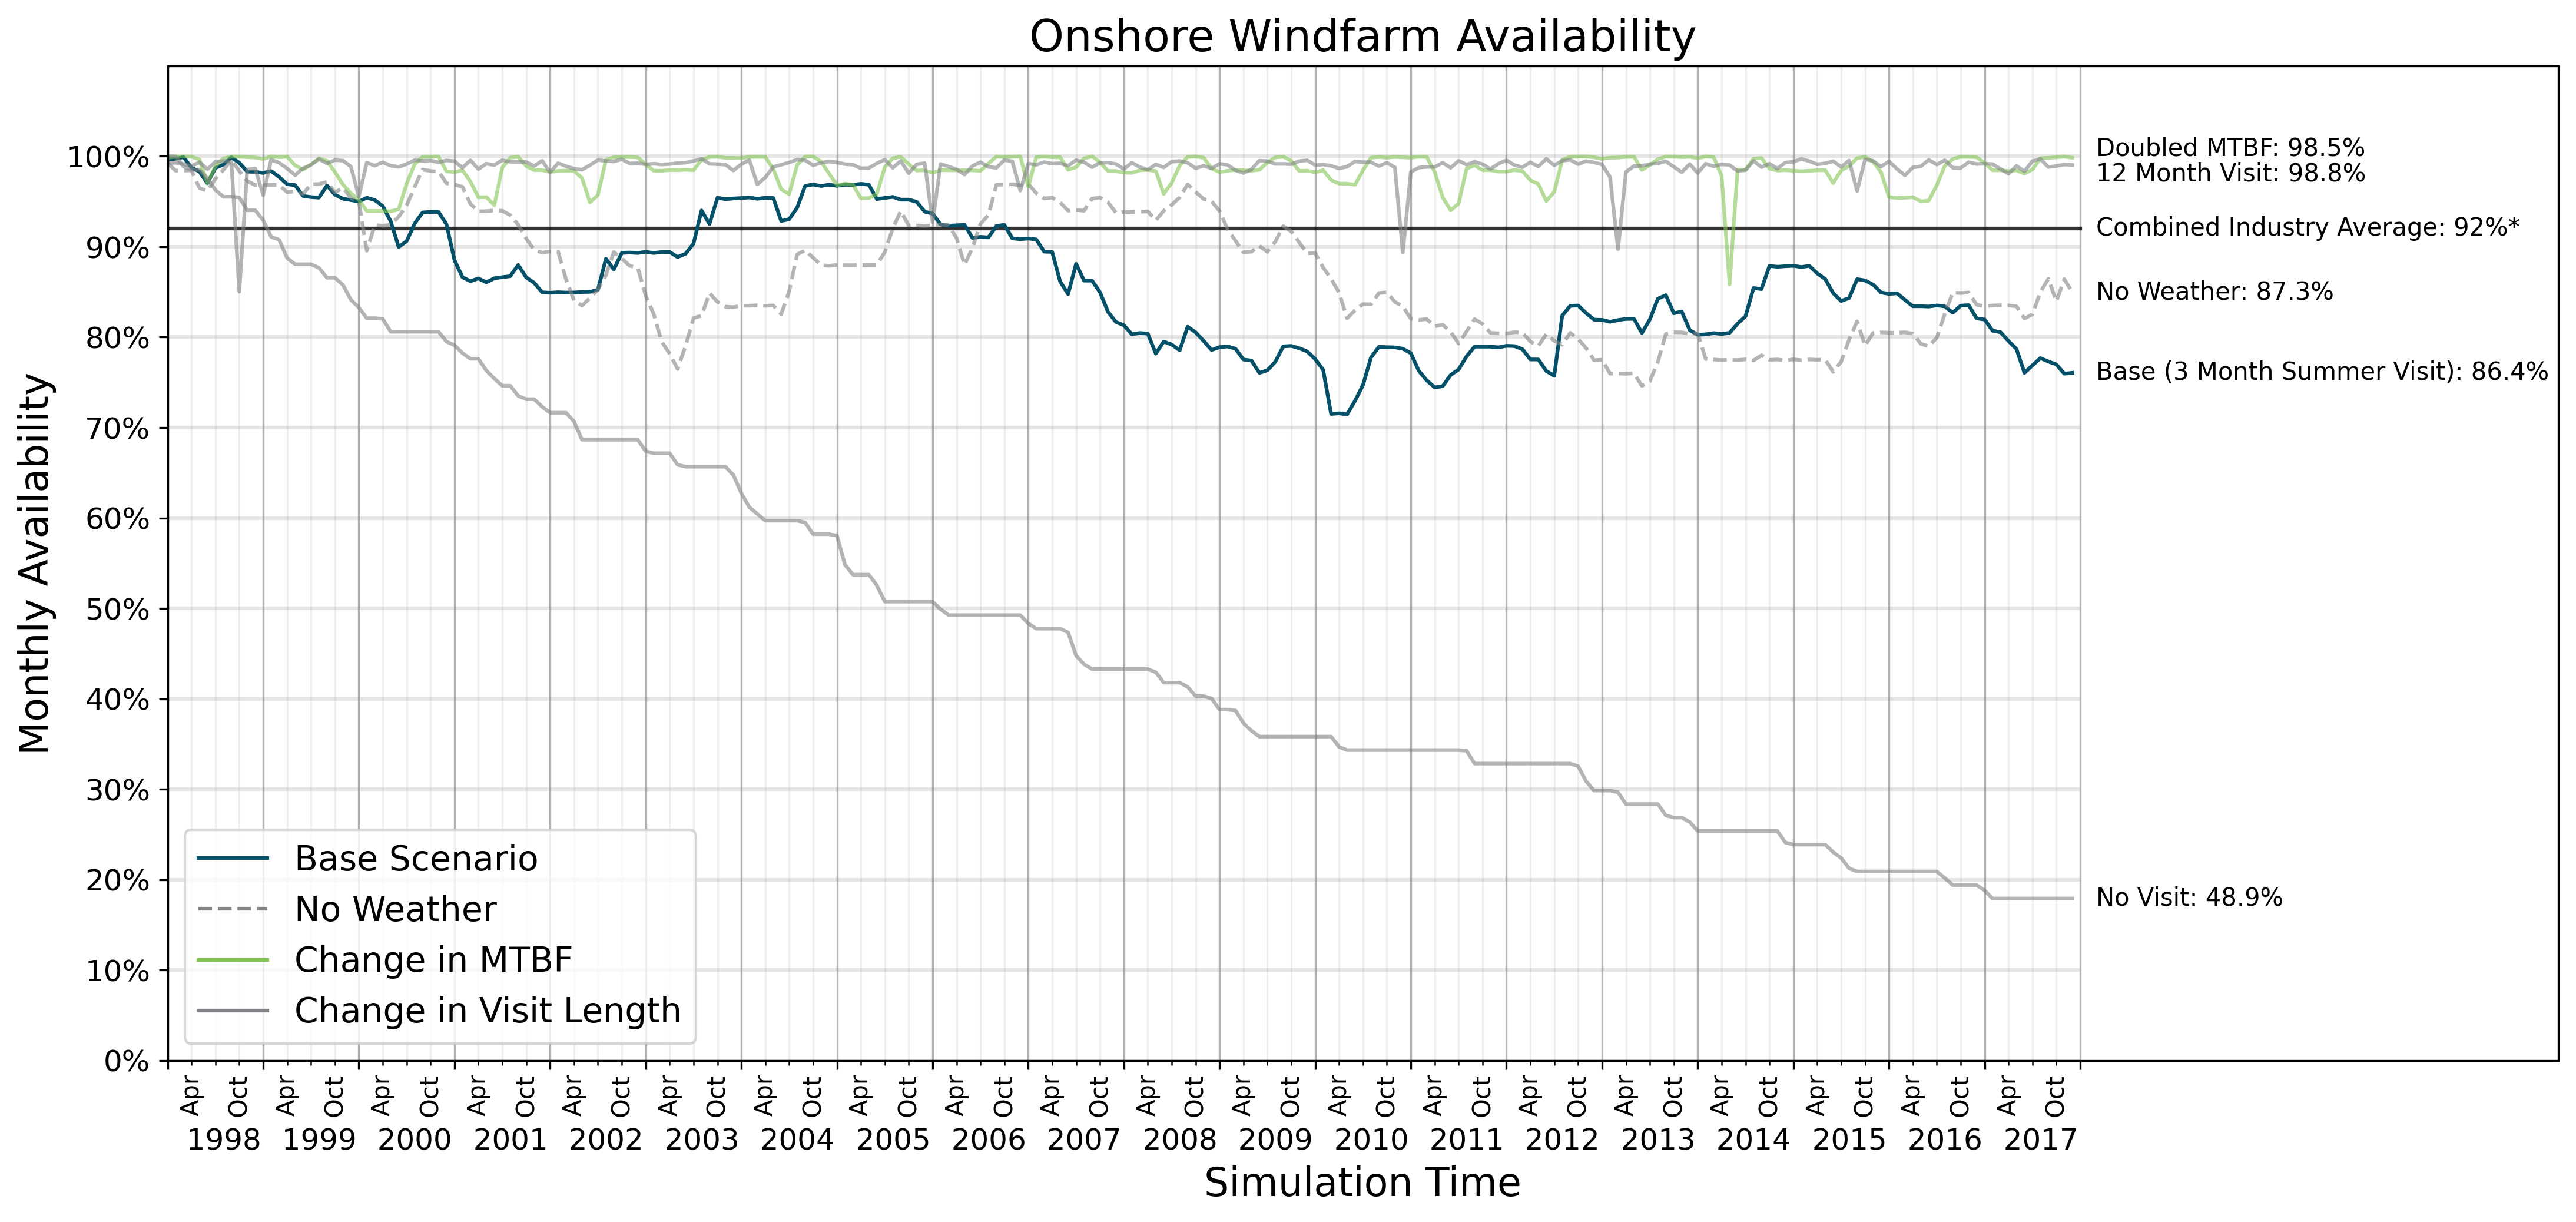

In [13]:
fig, ax = plt.subplots(figsize=(15, 7), dpi=300)

line_legend = []
for formatting in format_categories:
    line = mlines.Line2D(
        [],
        [],
        color=formatting["color"],
        linestyle=formatting["linestyle"],
        label=formatting["name"],
    )
    line_legend.append(line)

ax.plot(np.arange(241), np.repeat(0.92, 241), alpha=0.8, color="black")
ax.text(242, 0.92, "Combined Industry Average: 92%*", va="center")

for scenario in data_frames:
    if scenario.startswith("offshore") or scenario.endswith("v2"):
        continue

    operations = data_frames[scenario]["operations"]
    monthly_availability, project_availability = get_availability_data(operations)
    data_frames[scenario]["monthly_availability"] = monthly_availability
    data_frames[scenario]["project_availability"] = project_availability

    fmt = format_dict[scenario]["format"]
    ax.plot(
        range(monthly_availability.shape[0]),
        monthly_availability.windfarm.values,
        color=fmt["color"],
        linestyle=fmt["linestyle"],
        alpha=fmt["alpha"],
    )

    name = format_dict[scenario]["name"]
    text = f"{name}: {project_availability * 100:.1f}%"
    y = monthly_availability.loc[2017].loc[12].values[0]
    #     print(f"{name:>40}: {y:>4.2f}")
    if name == "Doubled MTBF":
        y *= 1.01
    elif name == "12 Month Visit":
        y *= 0.99
    ax.text(242, y, f"{text}", va="center")

xticks_major = [x * 12 for x in range(21)]
xticks_minor = list(range(0, 12 * 20, 3))
xlabels_major = [f"{year:>6}" for year in years]
xlabels_minor = ["Apr", "", "Oct"] + ["Apr", "", "Oct"] * 19
ax.set_xlabel("Simulation Time", fontsize=16)

ax.set_ylim(0, 1.1)
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_ylabel("Monthly Availability", fontsize=16)
ax.set_yticklabels([f"{y * 100:.0f}%" for y in ax.get_yticks()], fontsize=12)

ax.set_xlim(0, 300)
ax.set_xticks(xticks_major)
for t in ax.get_xticklabels():
    t.set_y(-0.05)
ax.set_xticks(xticks_minor, minor=True)
ax.set_xticklabels(xlabels_major, ha="left", fontsize=12)
ax.set_xticklabels(xlabels_minor, minor=True, rotation=90)

ax.set_title("Onshore Windfarm Availability", fontsize=18)
ax.legend(handles=line_legend, loc="lower left", fontsize=14)

plt.grid(axis="x", which="major")
plt.grid(alpha=0.2, which="minor")
ax.hlines(np.linspace(0, 1, 11), 0, 240, alpha=0.2, color="gray")

fig.tight_layout()
plt.savefig(
    os.path.join(
        library_path, "outputs/plots_and_tables/presentation/onshore_availability.png"
    ),
    bbox_to_inches="tight",
)
plt.savefig(
    os.path.join(
        library_path, "outputs/plots_and_tables/presentation/onshore_availability.svg"
    ),
    bbox_to_inches="tight",
)

## Offshore Cost Comparison

/opt/miniconda3/envs/wombat/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


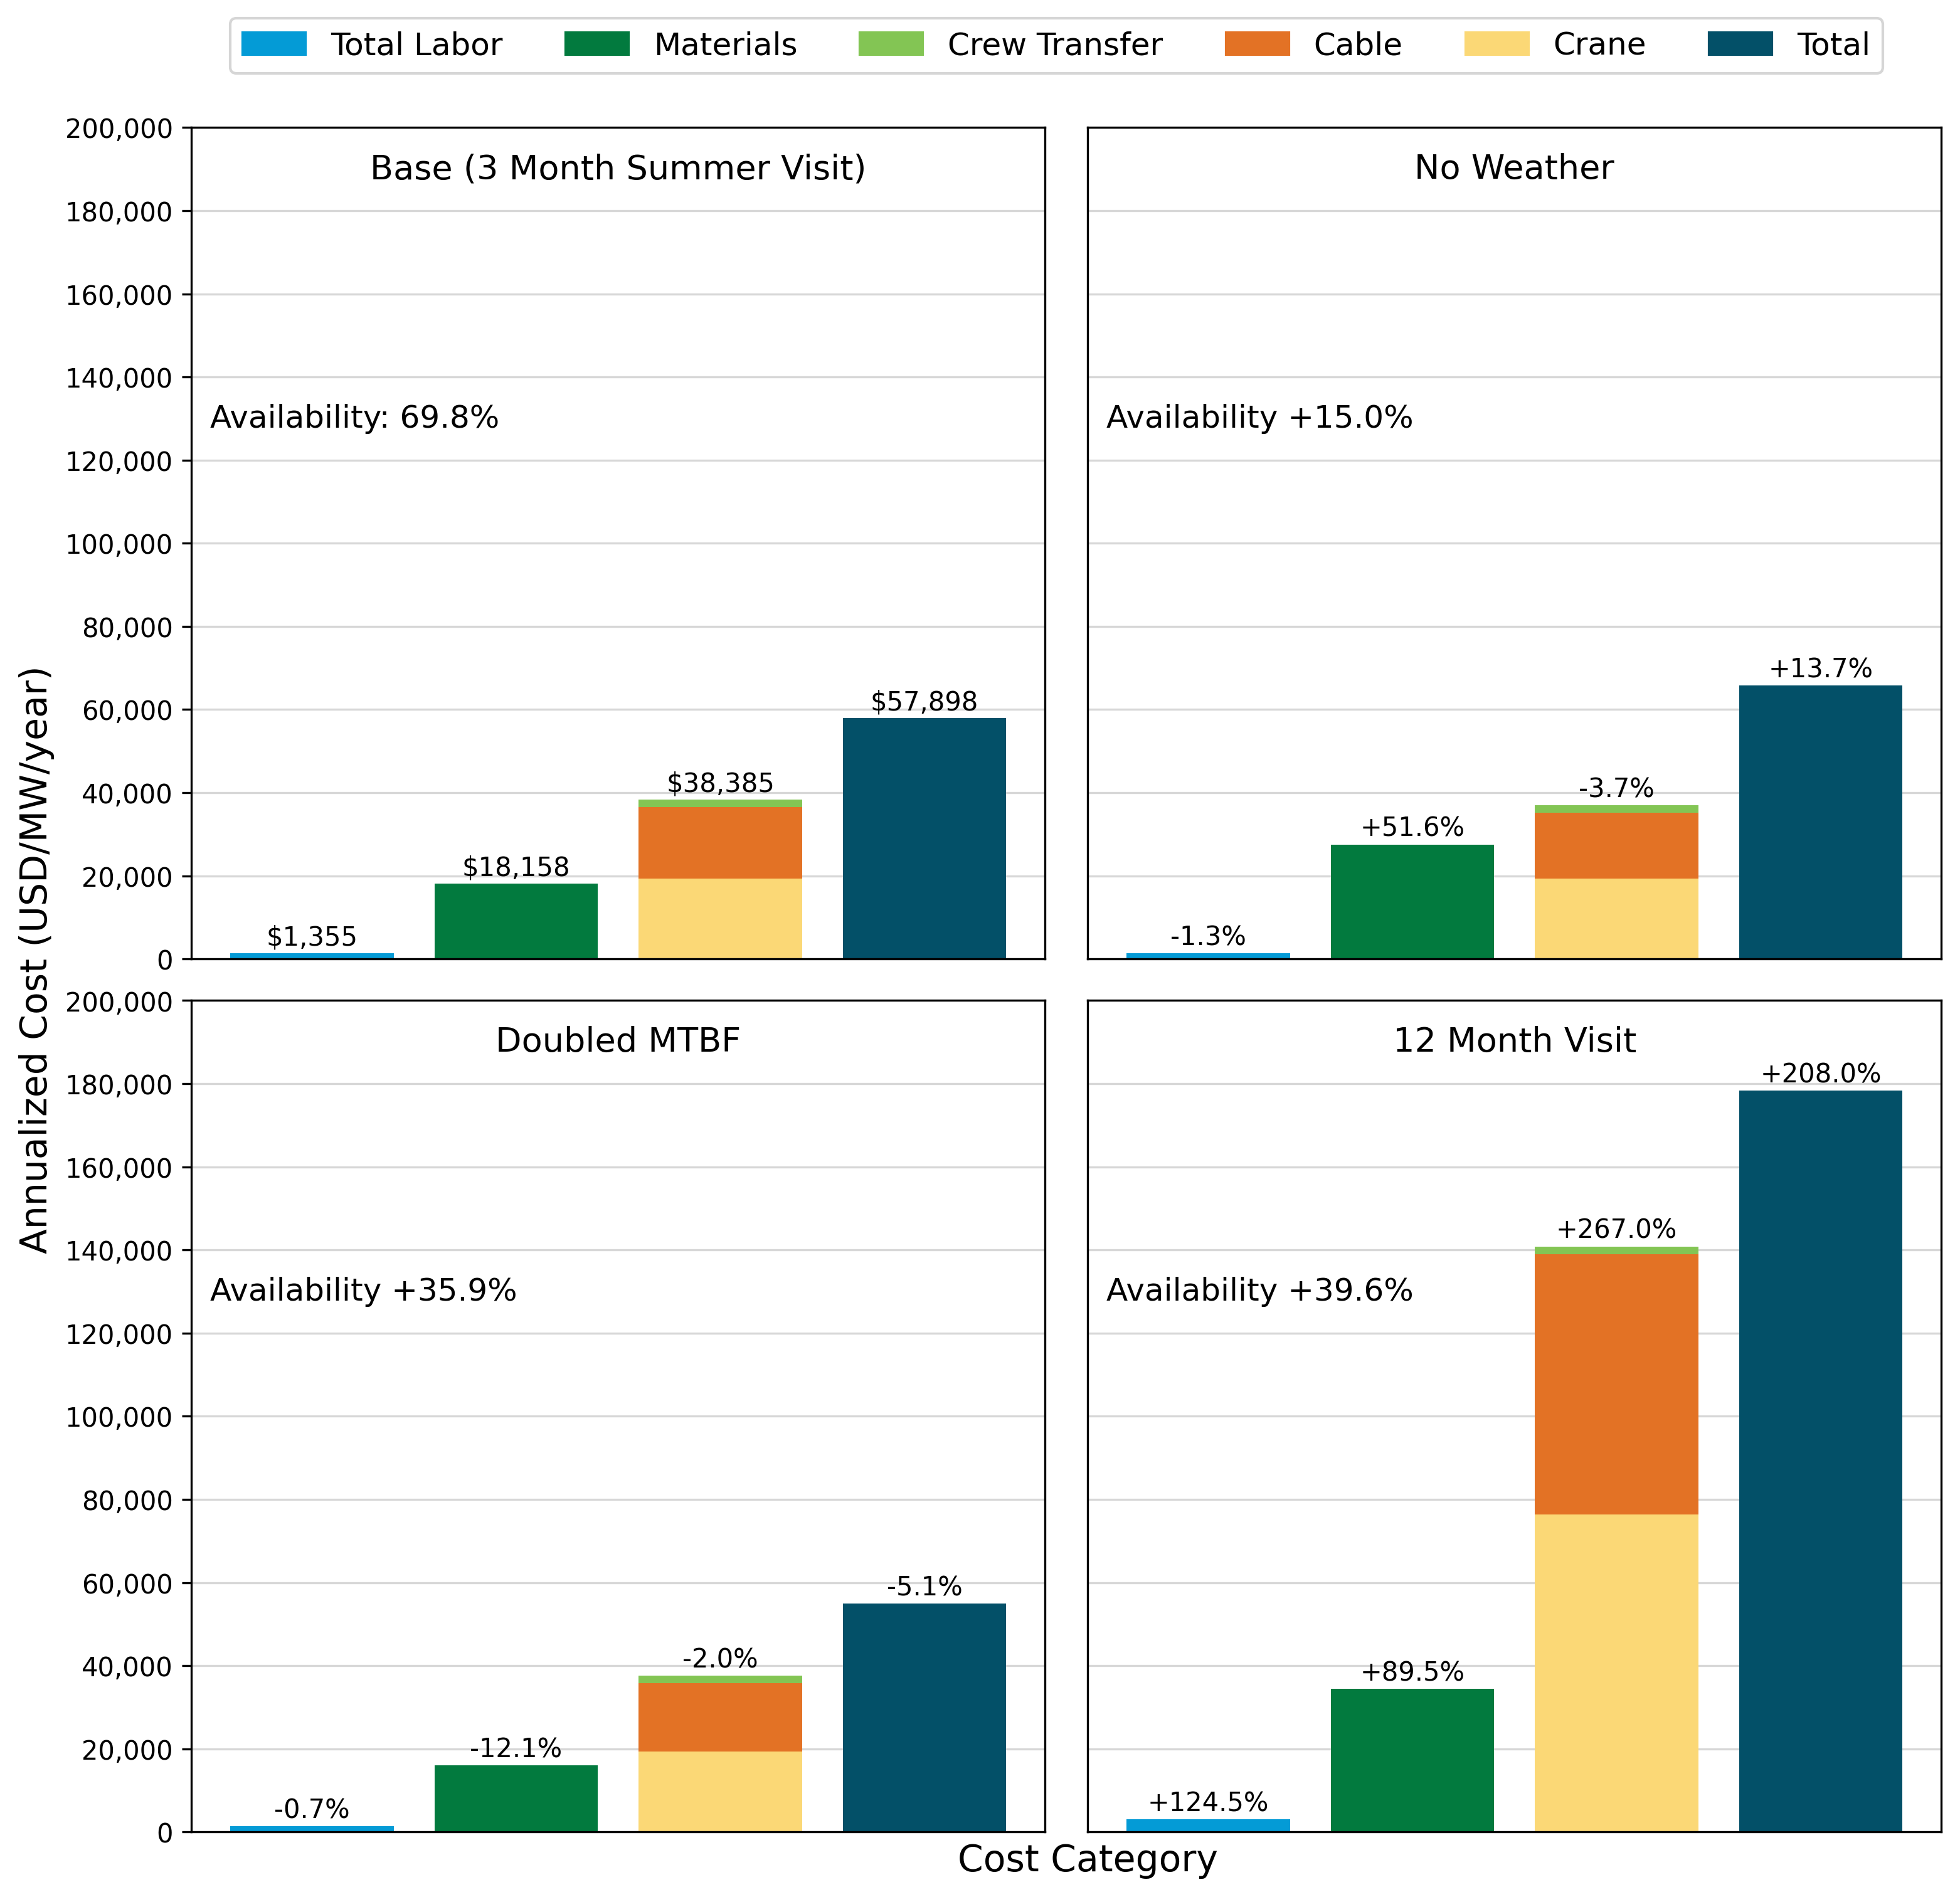

In [14]:
fig = plt.figure(figsize=(12, 12), dpi=300)
axes = fig.subplots(
    2,
    2,
    sharey=True,
    subplot_kw=dict(ylim=(0, 200000), yticks=range(0, 200001, 20000)),
    gridspec_kw=dict(wspace=0.05, hspace=0.05),
)

x = range(len(cost_columns))
x_labels = [cost_format_dict[x]["name"] for x in cost_columns]
major_cat_colors = [cost_format_dict[x]["color"] for x in cost_columns]
offshore_equipment_colors = [cost_format_dict[e]["color"] for e in offshore_equipment]

patches = []
for name, color in [
    *zip(x_labels[:-2], major_cat_colors[:-2]),
    *reversed(list(zip(offshore_equipment, offshore_equipment_colors))),
    (x_labels[-1], major_cat_colors[-1]),
]:
    name = cost_format_dict[name]["name"] if name in offshore_equipment else name
    patch = mpatches.Patch(color=color, label=name)
    patches.append(patch)

scenario = "offshore_base_3_month_summer"
base_costs = costs = (
    data_frames[scenario]["events"][cost_columns].sum(axis=0)
    / offshore_total_mw
    / len(years)
)
base_availability = data_frames[scenario]["project_availability"]

_data_frames = {
    name: values
    for name, values in data_frames.items()
    if name.startswith("offshore") and name != "offshore_0_month"
}
for scenario, ax in zip(_data_frames, axes.flatten()):
    name = format_dict[scenario]["name"]
    events = data_frames[scenario]["events"]

    costs = events[cost_columns].sum(axis=0)
    annual_mw_costs = costs / offshore_total_mw / len(years)
    availability = data_frames[scenario]["project_availability"]

    vals = annual_mw_costs.copy()
    vals.loc["equipment_cost"] = 0

    equip_ix = cost_columns.index("equipment_cost")
    offshore_equipment_costs = (
        events[events.equipment_cost > 0].groupby("agent").sum().equipment_cost
        / offshore_total_mw
        / len(years)
    )

    bottom = np.zeros(annual_mw_costs.size)
    for i, e in enumerate(offshore_equipment):
        _colors = deepcopy(major_cat_colors)
        _colors[equip_ix] = cost_format_dict[e]["color"]
        y = vals.values
        if i > 0:
            y = np.zeros(vals.size)
        try:
            y[equip_ix] = offshore_equipment_costs.loc[e]
            ax.bar(x, y, color=_colors, bottom=bottom)
        except KeyError:
            pass
        bottom += y

    if scenario != "offshore_base_3_month_summer":
        cost_diff = (annual_mw_costs.values - base_costs.values) / base_costs.values
        cost_diff_text = [f"{'+' if d > 0 else ''}{d * 100:.1f}%" for d in cost_diff]
        for i, (y, text) in enumerate(zip(bottom, cost_diff_text)):
            ax.text(i, y + 2000, text, ha="center")

        availability_diff = (availability - base_availability) / base_availability
        availability_diff_text = f"Availability {'+' if availability_diff > 0 else ''}{availability_diff * 100:.1f}%"
        ax.text(
            -0.5, 130000, availability_diff_text, ha="left", va="center", fontsize=12
        )
    else:
        cost_text = [f"${cost:,.0f}" for cost in base_costs]
        for i, (y, text) in enumerate(zip(base_costs, cost_text)):
            ax.text(i, y + 2000, text, ha="center")

        text = f"Availability: {base_availability * 100:.1f}%"
        ax.text(-0.5, 130000, text, ha="left", va="center", fontsize=12)

    ax.text(1.5, 190000, name, fontsize=13, ha="center", va="center")

    ax.set_yticklabels([f"{y:,.0f}" for y in ax.get_yticks()])
    ax.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)

    ax.grid(axis="y", alpha=0.5)
    ax.set_axisbelow(True)

axes[0, 0].legend(
    handles=patches, loc="upper right", ncol=6, fontsize=12, bbox_to_anchor=(2, 1.15)
)
axes[1, 0].set_ylabel(
    "Annualized Cost (USD/MW/year)",
    fontsize=14,
    x=-0.2,
    y=1.05,
    ha="center",
    va="bottom",
)
axes[1, 0].set_xlabel(
    "Cost Category",
    fontsize=14,
    x=1.05,
    ha="center",
    va="top",
)

for ax in axes[:, 1:].flatten():
    ax.tick_params(
        axis="y",
        which="both",
        left=False,
        right=False,
        labelleft=False,
        labelright=False,
    )


fig.tight_layout()
plt.savefig(
    os.path.join(
        library_path, "outputs/plots_and_tables/presentation/offshore_costs.png"
    ),
    bbox_inches="tight",
)
plt.savefig(
    os.path.join(
        library_path, "outputs/plots_and_tables/presentation/offshore_costs.svg"
    ),
    bbox_inches="tight",
)

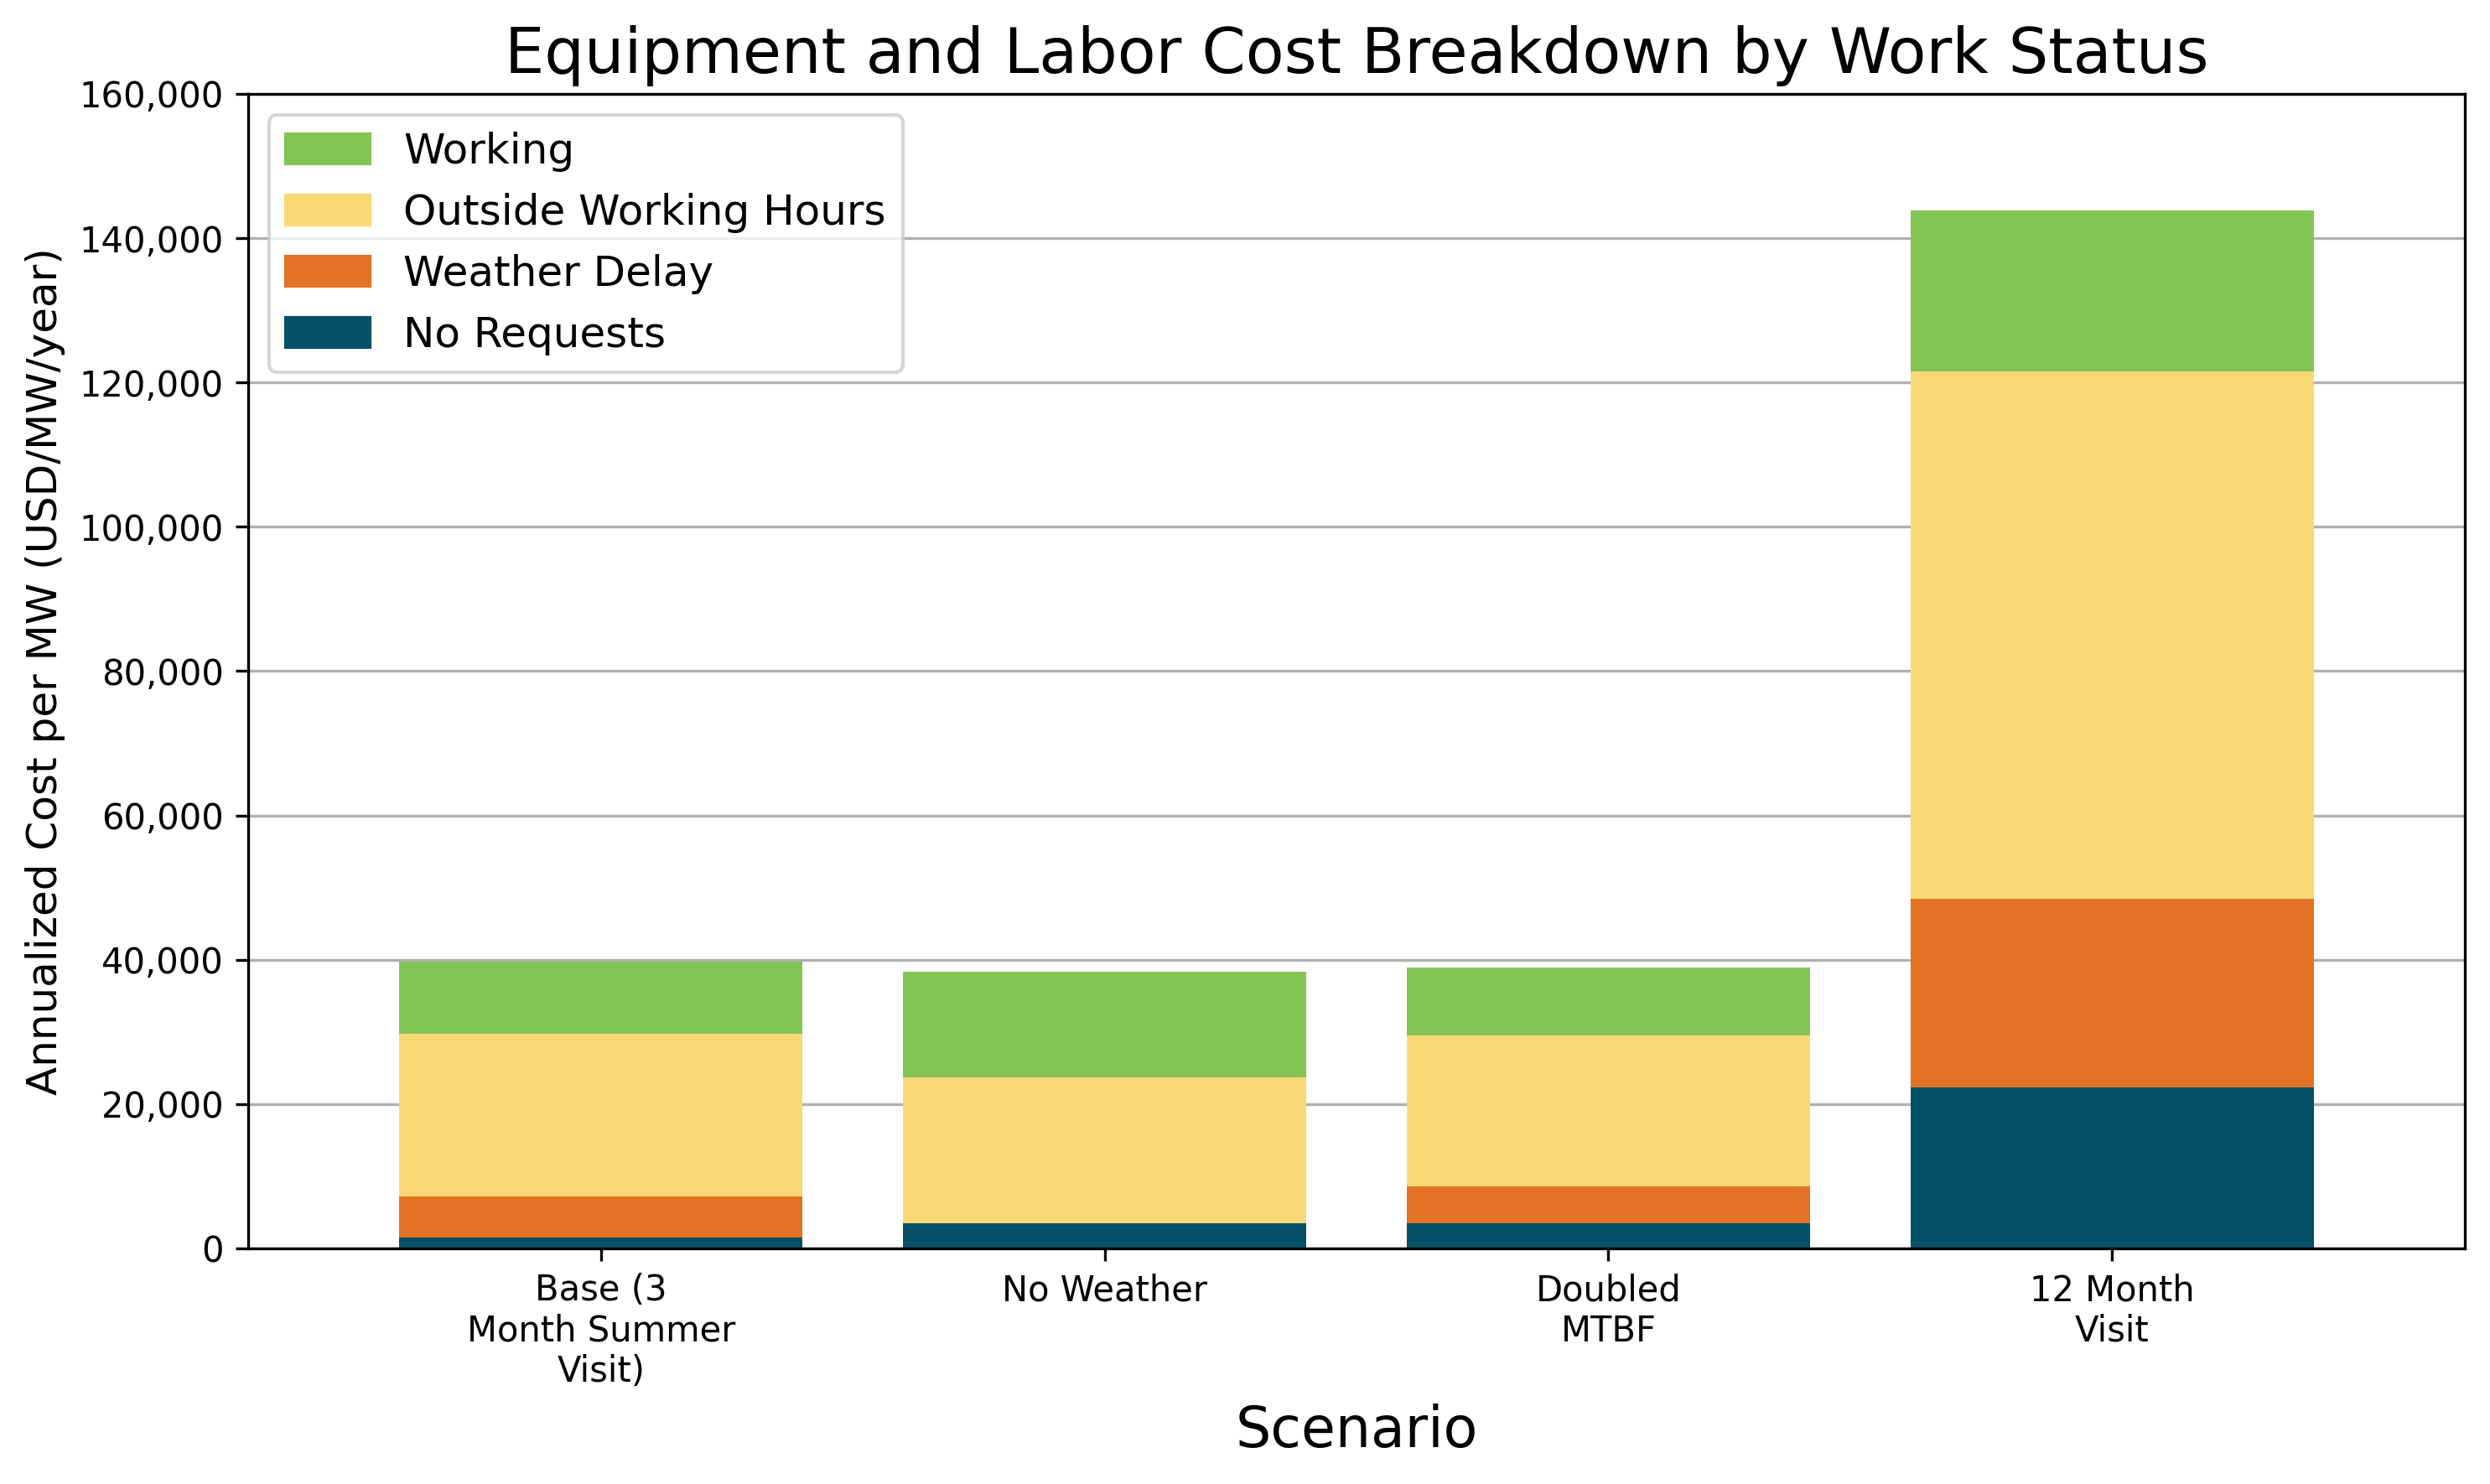

In [15]:
fig = plt.figure(figsize=(10, 6), dpi=300)
ax = fig.add_subplot(111)

colors = ["#035068", "#E37225", "#FBD876", "#83C554"]
indices = ["No Requests", "Weather Delay", "Outside Working Hours", "Working"]
_data_frames = {
    name: values for name, values in data_frames.items() if name.startswith("offshore")
}
x_tick_labels = [format_dict[s]["name"] for s in _data_frames]
y_ticks = range(0, 160001, 20000)

scenario = "offshore_base_3_month_summer"
name = format_dict[scenario]["name"]
# events = data_frames[scenario]["events"]
# equip_labor = equipment_labor_cost_breakdown(events, equipment, offshore_total_mw, 20).values

patches = []
for name, color in zip(indices, colors):
    patch = mpatches.Patch(color=color, label=name)
    patches.append(patch)

for i, scenario in enumerate(_data_frames):
    if all(s is None for s in scenarios[scenario][2:]):
        continue
    name = format_dict[scenario]["name"]
    events = data_frames[scenario]["events"]
    equip_labor = equipment_labor_cost_breakdown(
        events, offshore_equipment, offshore_total_mw, 20
    )

    bottom = 0
    for c, ix in zip(colors, indices):
        if ix not in equip_labor.index:
            continue
        ax.bar(i, equip_labor.loc[ix], bottom=bottom, color=c)
        bottom += equip_labor.loc[ix]

ax.set_xticks(range(len(x_tick_labels)))
ax.set_xticklabels(
    [make_label_multi_lines(x, longest_line_length=10) for x in x_tick_labels],
    fontsize=10,
)
ax.set_yticks(y_ticks)
ax.set_yticklabels([f"{y:,.0f}" for y in y_ticks], fontsize=10)

ax.set_title("Equipment and Labor Cost Breakdown by Work Status", fontsize=18)
ax.set_xlabel("Scenario", fontsize=16)
ax.set_ylabel("Annualized Cost per MW (USD/MW/year)", fontsize=12)

ax.set_xlim(-0.7, 3.7)
ax.legend(handles=list(reversed(patches)), ncol=1, fontsize=12, loc="upper left")

ax.grid(axis="y")
ax.set_axisbelow(True)

fig.tight_layout()
plt.savefig(
    os.path.join(
        library_path,
        "outputs/plots_and_tables/presentation/offshore_equipment_labor_breakdown.png",
    ),
    bbox_inches="tight",
)
plt.savefig(
    os.path.join(
        library_path,
        "outputs/plots_and_tables/presentation/offshore_equipment_labor_breakdown.svg",
    ),
    bbox_inches="tight",
)

In [16]:
availability, annual_mw_costs

(0.9749954028624843,
 total_labor_cost      3041.828731
 materials_cost       34406.686567
 equipment_cost      140861.746269
 total_cost          178310.261567
 dtype: float64)

In [17]:
data_frames[scenario]["operations"].year.unique()

array([1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017])

## Offshore Cost vs Availability Comparison

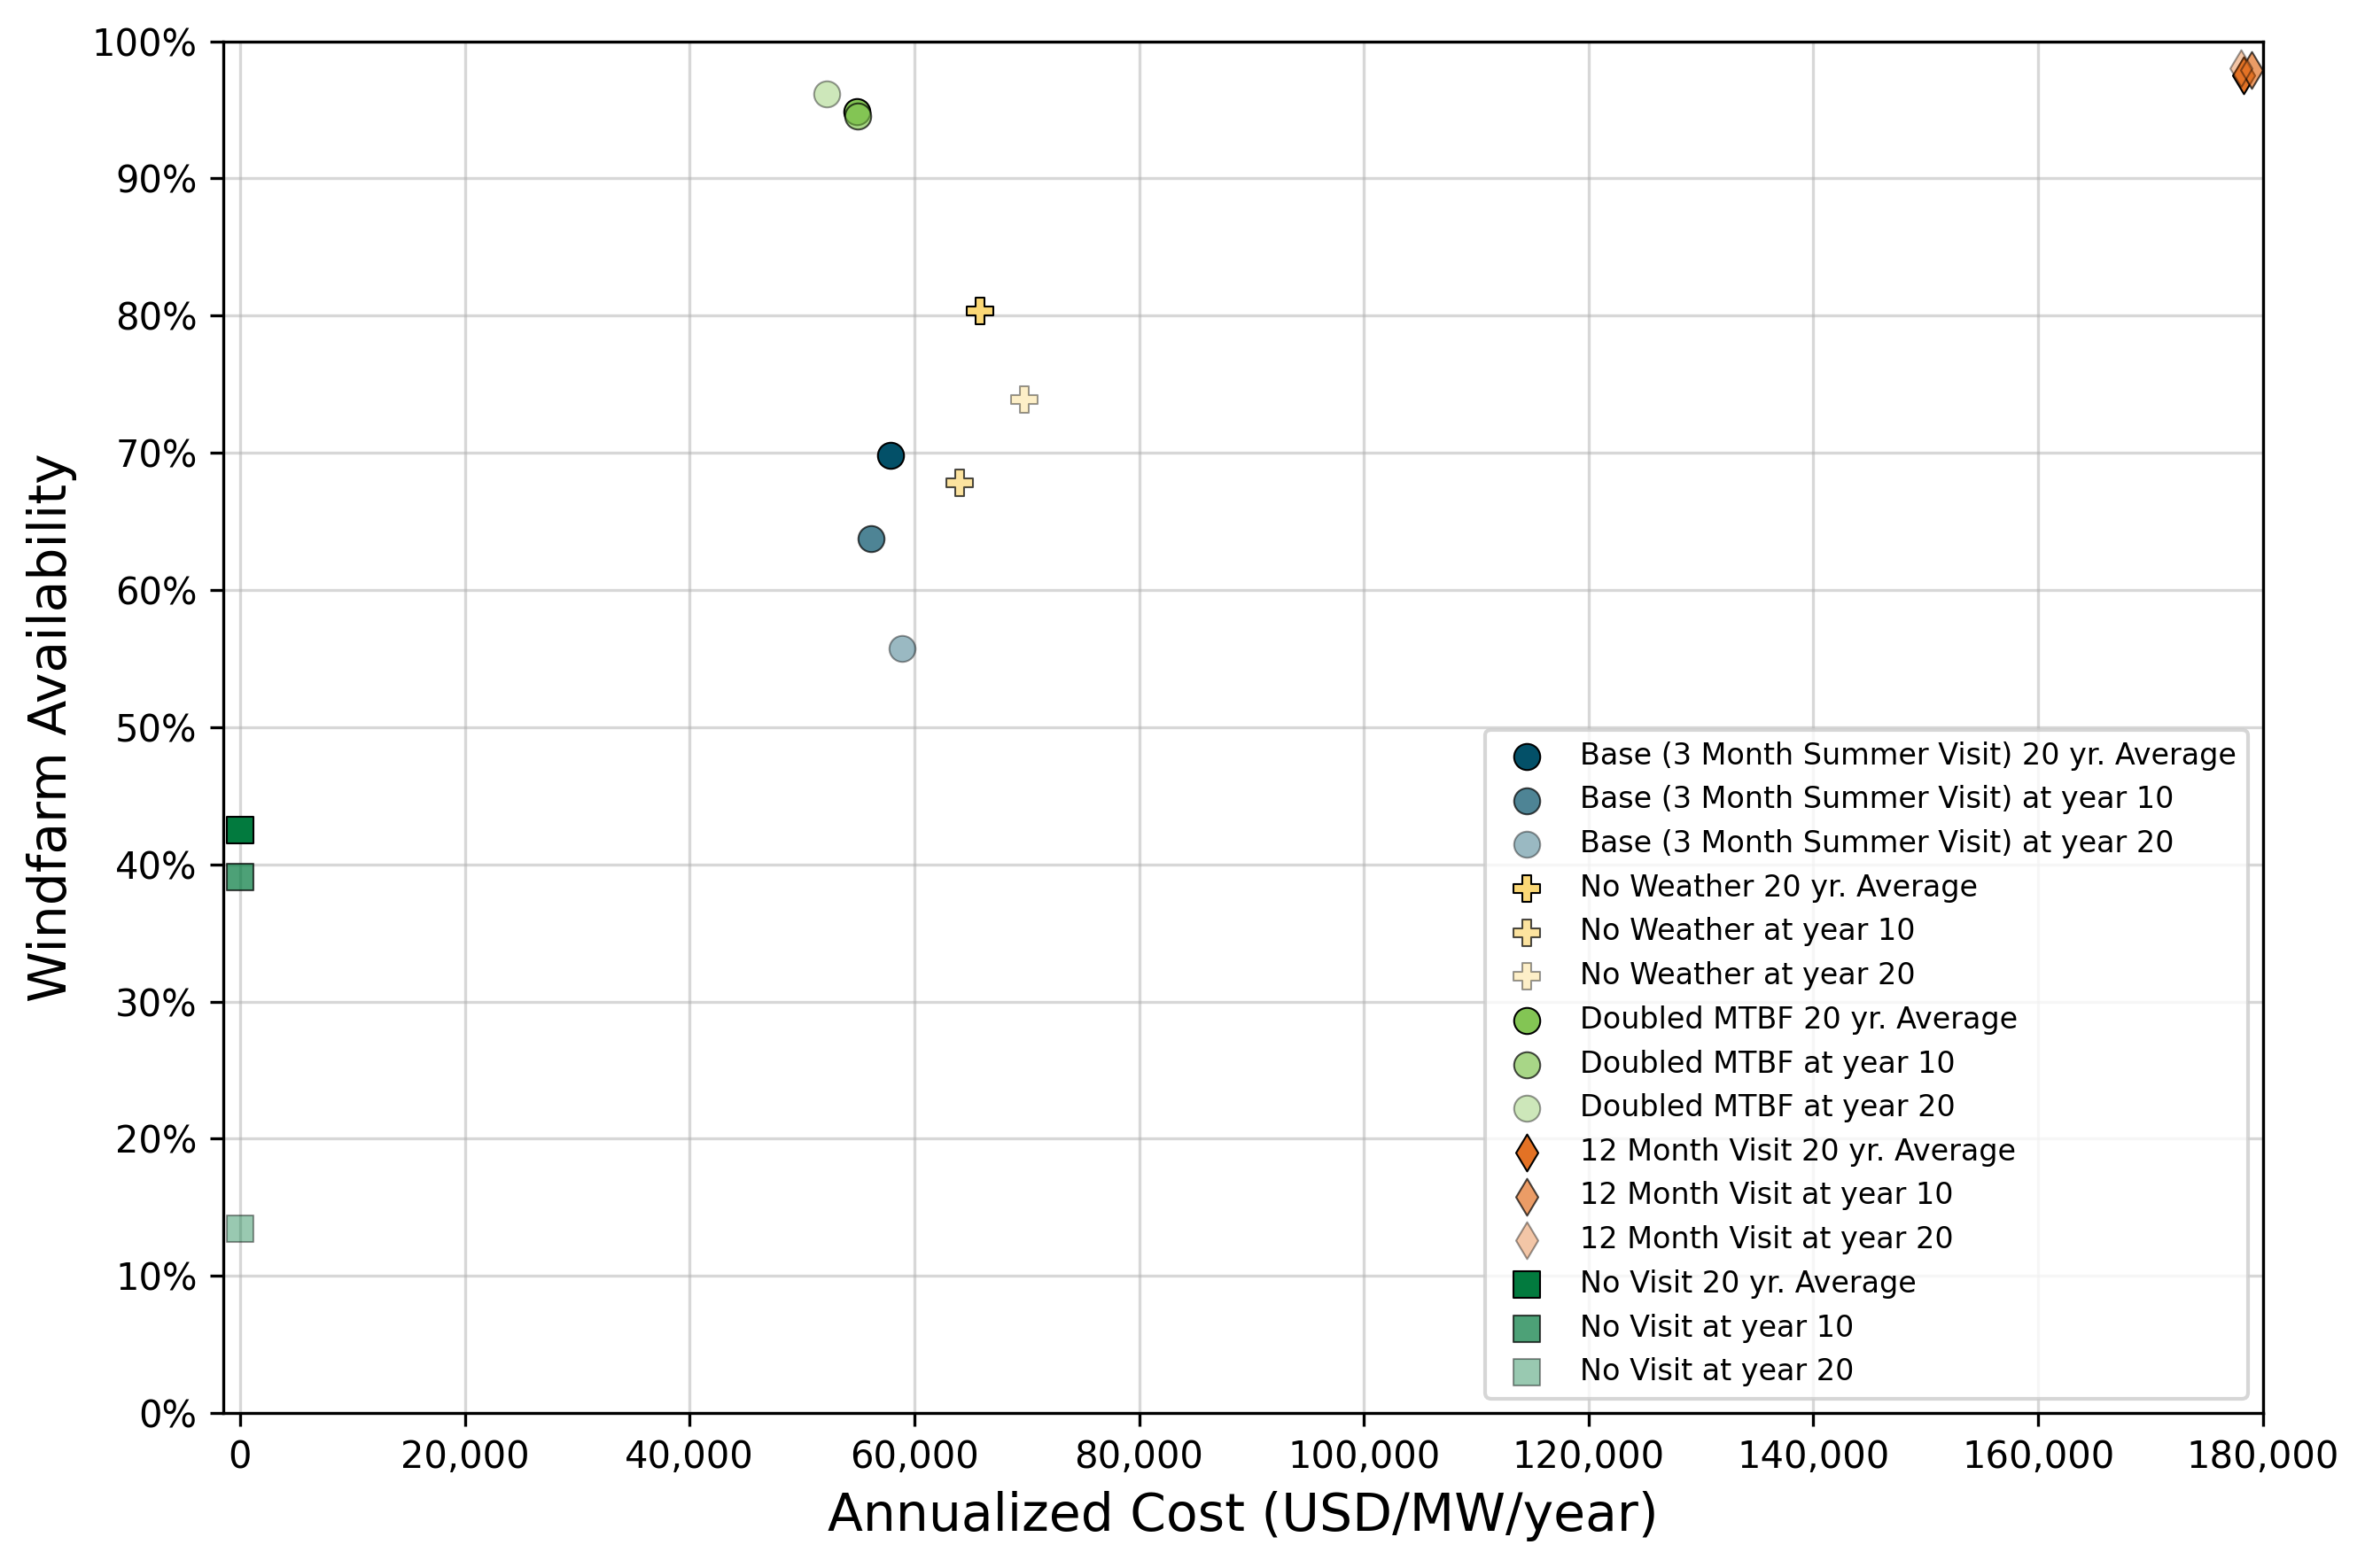

In [18]:
fig = plt.figure(figsize=(9, 6), dpi=300)
ax = fig.add_subplot(111)

x_ticks = range(0, 180001, 20000)
ax.set_xticks(x_ticks)
ax.set_xticklabels([f"{x:,.0f}" for x in x_ticks])

y_ticks = range(0, 101, 10)
ax.set_yticks(y_ticks)
ax.set_yticklabels([f"{y:.0f}%" for y in y_ticks])

ax.grid(alpha=0.5)
ax.set_axisbelow(True)

ax.set_xlim(-1500, 180000)
ax.set_ylim(0, 100)

ax.set_xlabel("Annualized Cost (USD/MW/year)", fontsize=14)
ax.set_ylabel("Windfarm Availability", fontsize=14)

arrow_props = arrowprops = dict(arrowstyle="-", linewidth=0.5, zorder=0)

_data_frames = {
    name: values for name, values in data_frames.items() if name.startswith("offshore")
}
for scenario in _data_frames:
    name = format_dict[scenario]["name"]
    events = data_frames[scenario]["events"]
    fmt = format_dict[scenario]["format"]

    costs = data_frames[scenario]["events"][["year", "total_cost"]]
    costs = [
        costs[costs.year == 2007].total_cost.sum(),
        costs[costs.year == 2017].total_cost.sum(),
    ]
    costs = [
        data_frames[scenario]["events"].total_cost.sum()
        / offshore_total_mw
        / len(years)
    ] + [el / offshore_total_mw for el in costs]

    availability = data_frames[scenario]["operations"]
    availability = [
        get_availability_data(availability[availability.year == 2007])[1],
        get_availability_data(availability[availability.year == 2017])[1],
    ]
    availability = [data_frames[scenario]["project_availability"] * 100] + [
        el * 100 for el in availability
    ]

    ax.scatter(
        costs[0],
        availability[0],
        s=50,
        color=fmt["marker_color"],
        marker=fmt["marker"],
        edgecolor="black",
        linewidth=0.5,
        label=f"{name} 20 yr. Average",
    )
    ax.scatter(
        costs[1],
        availability[1],
        s=50,
        color=fmt["marker_color"],
        marker=fmt["marker"],
        alpha=0.7,
        edgecolor="black",
        linewidth=0.5,
        label=f"{name} at year 10",
    )
    ax.scatter(
        costs[2],
        availability[2],
        s=50,
        color=fmt["marker_color"],
        marker=fmt["marker"],
        alpha=0.4,
        edgecolor="black",
        linewidth=0.5,
        label=f"{name} at year 20",
    )

ax.legend(loc="lower right", fontsize=8)

fig.tight_layout()
plt.savefig(
    os.path.join(
        library_path,
        "outputs/plots_and_tables/presentation/offshore_cost_availability.png",
    ),
    bbox_to_inches="tight",
)
plt.savefig(
    os.path.join(
        library_path,
        "outputs/plots_and_tables/presentation/offshore_cost_availability.svg",
    ),
    bbox_to_inches="tight",
)

In [19]:
(
    events.groupby("part_name").sum()[["total_cost", "materials_cost"]]
    / offshore_total_mw
    / 20
).sort_values(["total_cost"], ascending=False)

total_cost  materials_cost
part_name                                       
array cable                  0.0             0.0
drive_train                  0.0             0.0
electrical_system            0.0             0.0
electronic_control           0.0             0.0
gearbox                      0.0             0.0
generator                    0.0             0.0
hydraulic_system             0.0             0.0
mechanical_brake             0.0             0.0
rotor_blades                 0.0             0.0
rotor_hub                    0.0             0.0
sensors                      0.0             0.0
supporting_structure         0.0             0.0
transformer                  0.0             0.0
yaw_system                   0.0             0.0

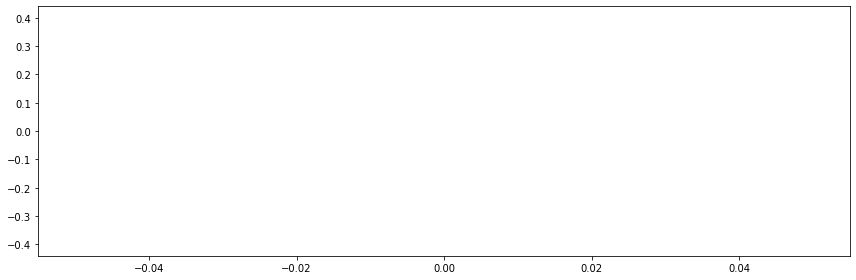

In [20]:
data = events.groupby("part_name").sum()[["total_cost", "materials_cost"]]
data = data / offshore_total_mw / 20
data = data.sort_values(["total_cost"], ascending=False)

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(111)

bottom = 0
for part in data.index.values:
    ax.barh(0, data.loc[part, "total_cost"], left=bottom)
    bottom += data.loc[part, "total_cost"]

fig.tight_layout()

## Onshore Cost Comparison

/opt/miniconda3/envs/wombat/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


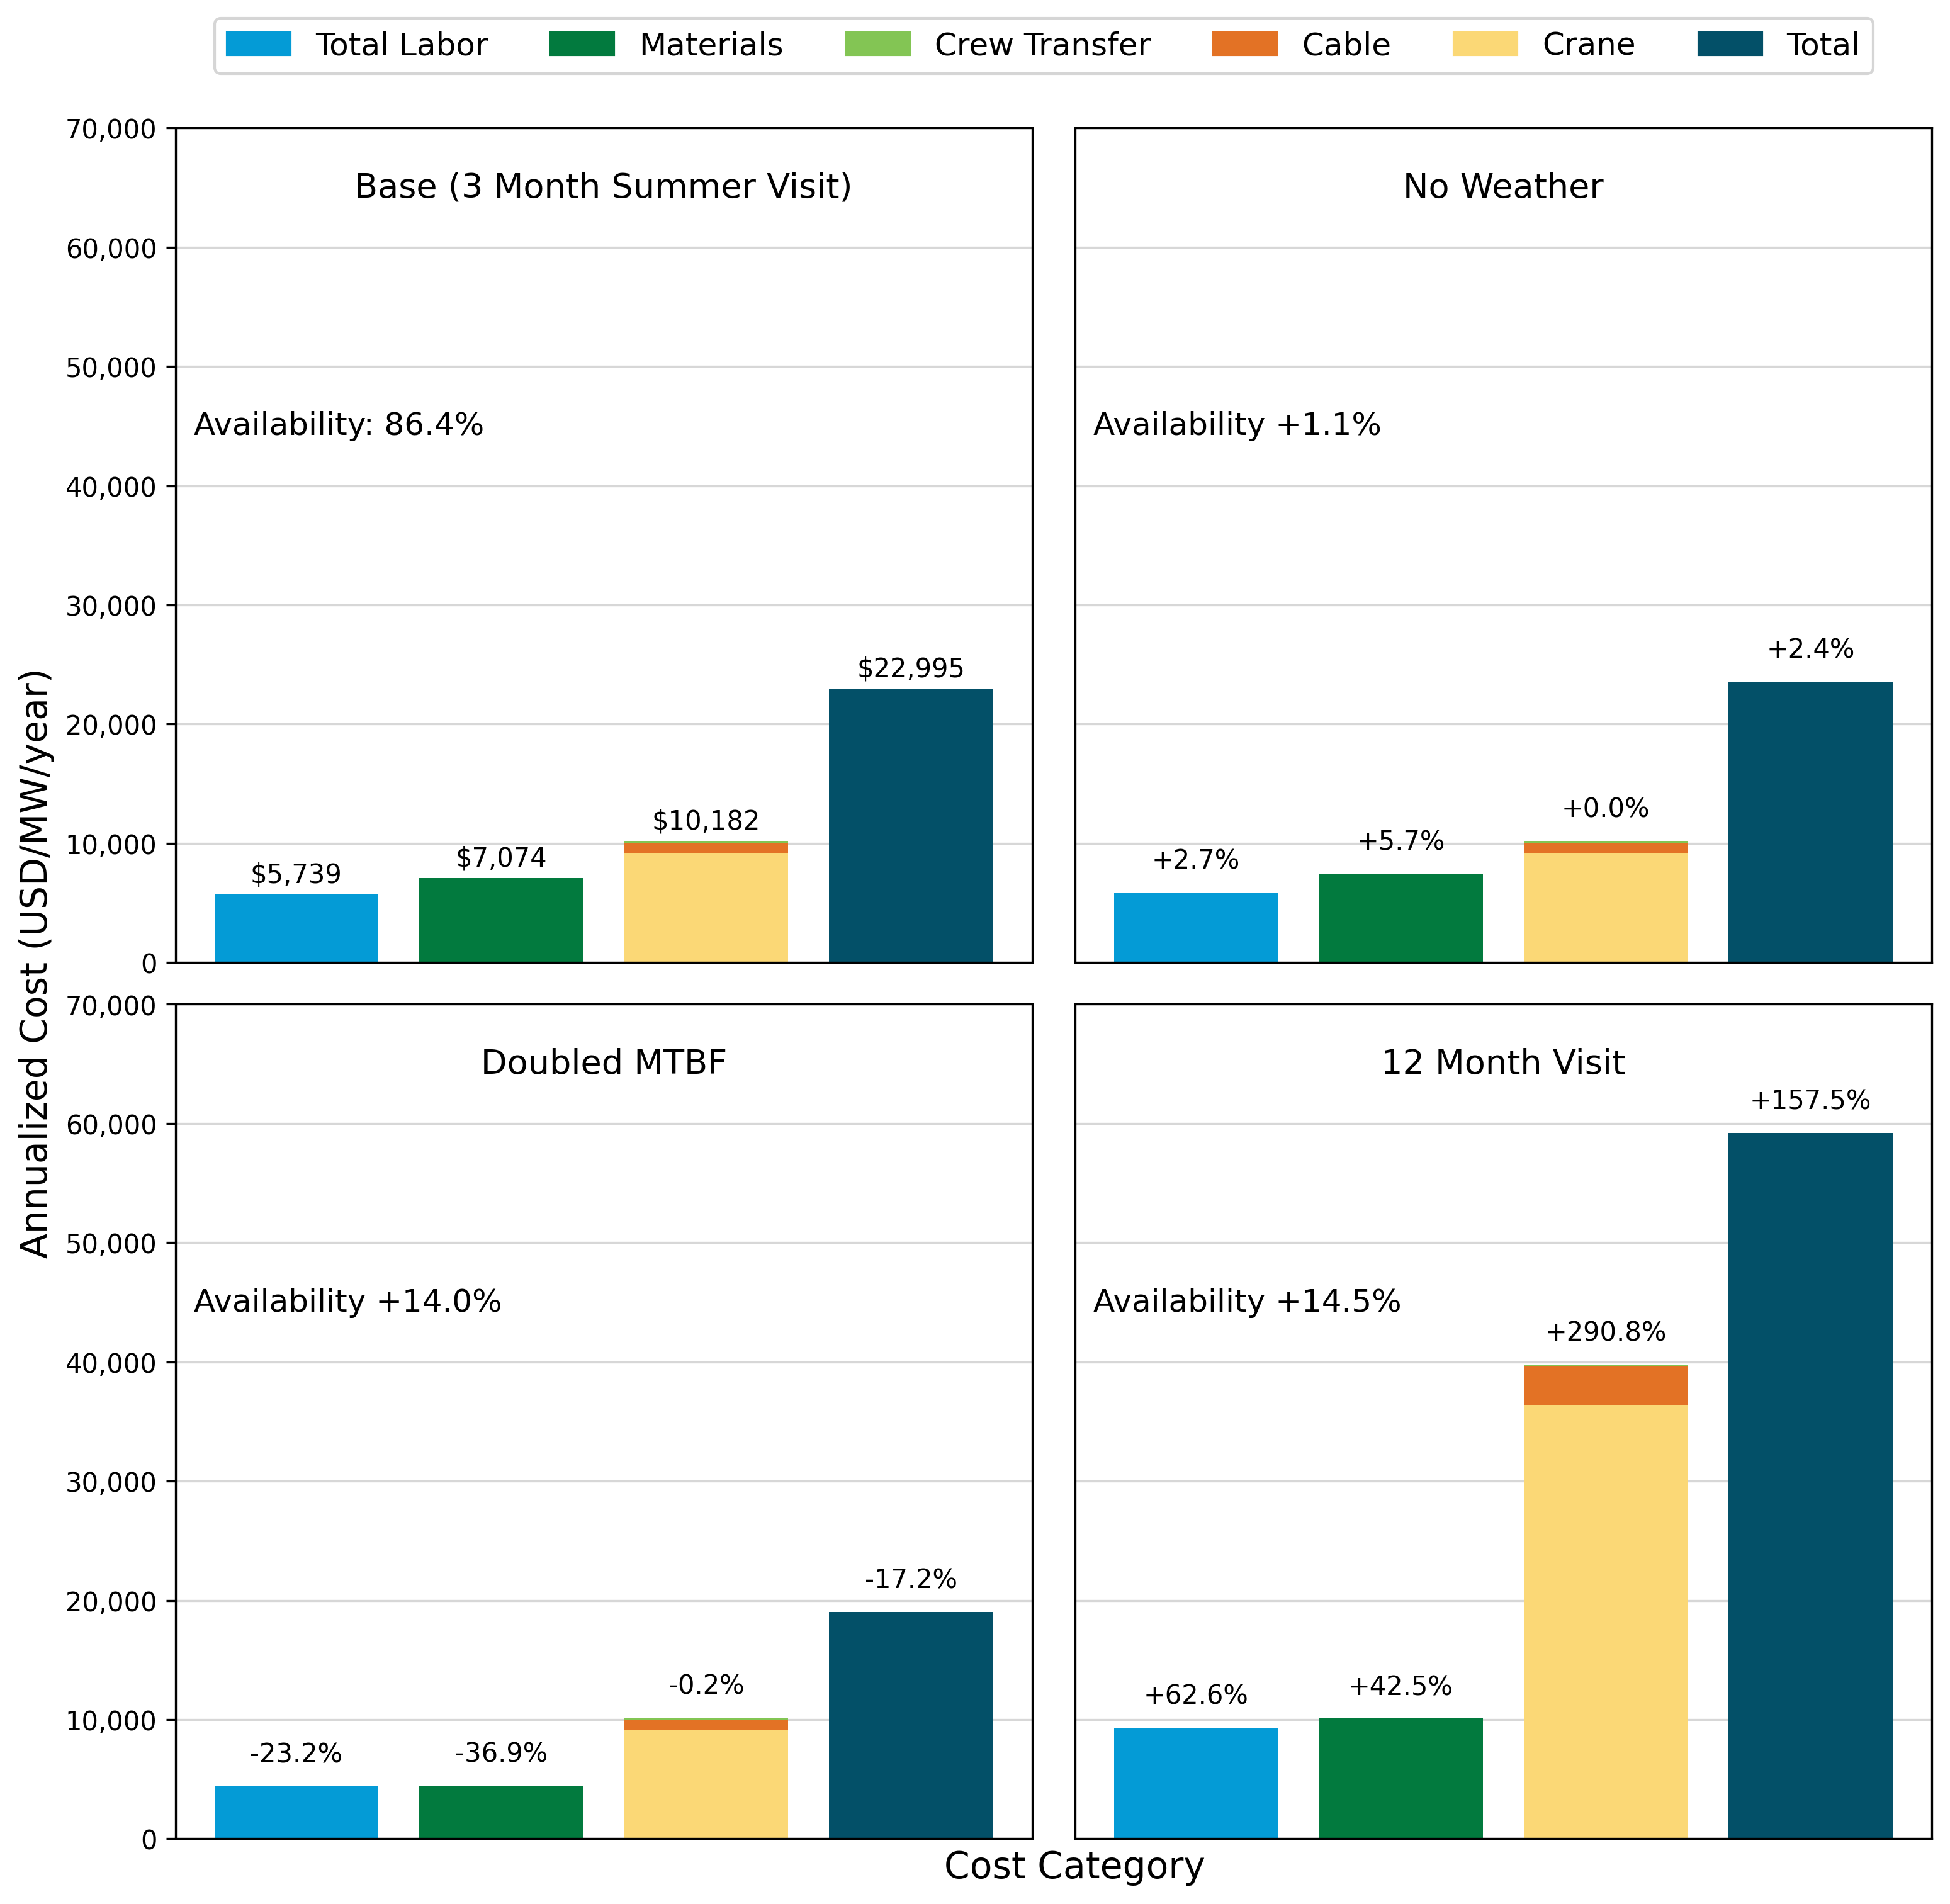

In [21]:
fig = plt.figure(figsize=(12, 12), dpi=300)
axes = fig.subplots(
    2,
    2,
    sharey=True,
    subplot_kw=dict(ylim=(0, 70000), yticks=range(0, 70001, 10000)),
    gridspec_kw=dict(wspace=0.05, hspace=0.05),
)

x = range(len(cost_columns))
x_labels = [cost_format_dict[x]["name"] for x in cost_columns]
major_cat_colors = [cost_format_dict[x]["color"] for x in cost_columns]
onshore_equipment_colors = [cost_format_dict[e]["color"] for e in onshore_equipment]

patches = []
for name, color in [
    *zip(x_labels[:-2], major_cat_colors[:-2]),
    *reversed(list(zip(onshore_equipment, onshore_equipment_colors))),
    (x_labels[-1], major_cat_colors[-1]),
]:
    name = cost_format_dict[name]["name"] if name in onshore_equipment else name
    patch = mpatches.Patch(color=color, label=name)
    patches.append(patch)

scenario = "onshore_base_3_month_summer"
base_costs = costs = (
    data_frames[scenario]["events"][cost_columns].sum(axis=0)
    / onshore_total_mw
    / len(years)
)
base_availability = data_frames[scenario]["project_availability"]

_data_frames = {
    name: values
    for name, values in data_frames.items()
    if name.startswith("onshore") and name != "onshore_0_month"
}
for scenario, ax in zip(_data_frames, axes.flatten()):
    name = format_dict[scenario]["name"]
    events = data_frames[scenario]["events"]

    costs = events[cost_columns].sum(axis=0)
    annual_mw_costs = costs / onshore_total_mw / len(years)
    availability = data_frames[scenario]["project_availability"]

    vals = annual_mw_costs.copy()
    vals.loc["equipment_cost"] = 0

    equip_ix = cost_columns.index("equipment_cost")
    onshore_equipment_costs = (
        events[events.equipment_cost > 0].groupby("agent").sum().equipment_cost
        / onshore_total_mw
        / len(years)
    )

    bottom = np.zeros(annual_mw_costs.size)
    for i, e in enumerate(onshore_equipment):
        _colors = deepcopy(major_cat_colors)
        _colors[equip_ix] = cost_format_dict[e]["color"]
        y = vals.values
        if i > 0:
            y = np.zeros(vals.size)
        try:
            y[equip_ix] = onshore_equipment_costs.loc[e]
            ax.bar(x, y, color=_colors, bottom=bottom)
        except KeyError:
            pass
        bottom += y

    if scenario != "onshore_base_3_month_summer":
        cost_diff = (annual_mw_costs.values - base_costs.values) / base_costs.values
        cost_diff_text = [f"{'+' if d > 0 else ''}{d * 100:.1f}%" for d in cost_diff]
        for i, (y, text) in enumerate(zip(bottom, cost_diff_text)):
            ax.text(i, y + 2000, text, ha="center")

        availability_diff = (availability - base_availability) / base_availability
        availability_diff_text = f"Availability {'+' if availability_diff > 0 else ''}{availability_diff * 100:.1f}%"
        ax.text(
            -0.5, 45000, availability_diff_text, ha="left", va="center", fontsize=12
        )
    else:
        cost_text = [f"${cost:,.0f}" for cost in base_costs]
        for i, (y, text) in enumerate(zip(base_costs, cost_text)):
            ax.text(i, y + 1000, text, ha="center")

        text = f"Availability: {base_availability * 100:.1f}%"
        ax.text(-0.5, 45000, text, ha="left", va="center", fontsize=12)

    ax.text(1.5, 65000, name, fontsize=13, ha="center", va="center")

    ax.set_yticklabels([f"{y:,.0f}" for y in ax.get_yticks()])
    ax.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)

    ax.grid(axis="y", alpha=0.5)
    ax.set_axisbelow(True)

axes[0, 0].legend(
    handles=patches, loc="upper right", ncol=6, fontsize=12, bbox_to_anchor=(2, 1.15)
)
axes[1, 0].set_ylabel(
    "Annualized Cost (USD/MW/year)",
    fontsize=14,
    x=-0.2,
    y=1.05,
    ha="center",
    va="bottom",
)
axes[1, 0].set_xlabel(
    "Cost Category",
    fontsize=14,
    x=1.05,
    ha="center",
    va="top",
)

for ax in axes[:, 1:].flatten():
    ax.tick_params(
        axis="y",
        which="both",
        left=False,
        right=False,
        labelleft=False,
        labelright=False,
    )


fig.tight_layout()
plt.savefig(
    os.path.join(
        library_path, "outputs/plots_and_tables/presentation/onshore_costs.png"
    ),
    bbox_inches="tight",
)
plt.savefig(
    os.path.join(
        library_path, "outputs/plots_and_tables/presentation/onshore_costs.svg"
    ),
    bbox_inches="tight",
)

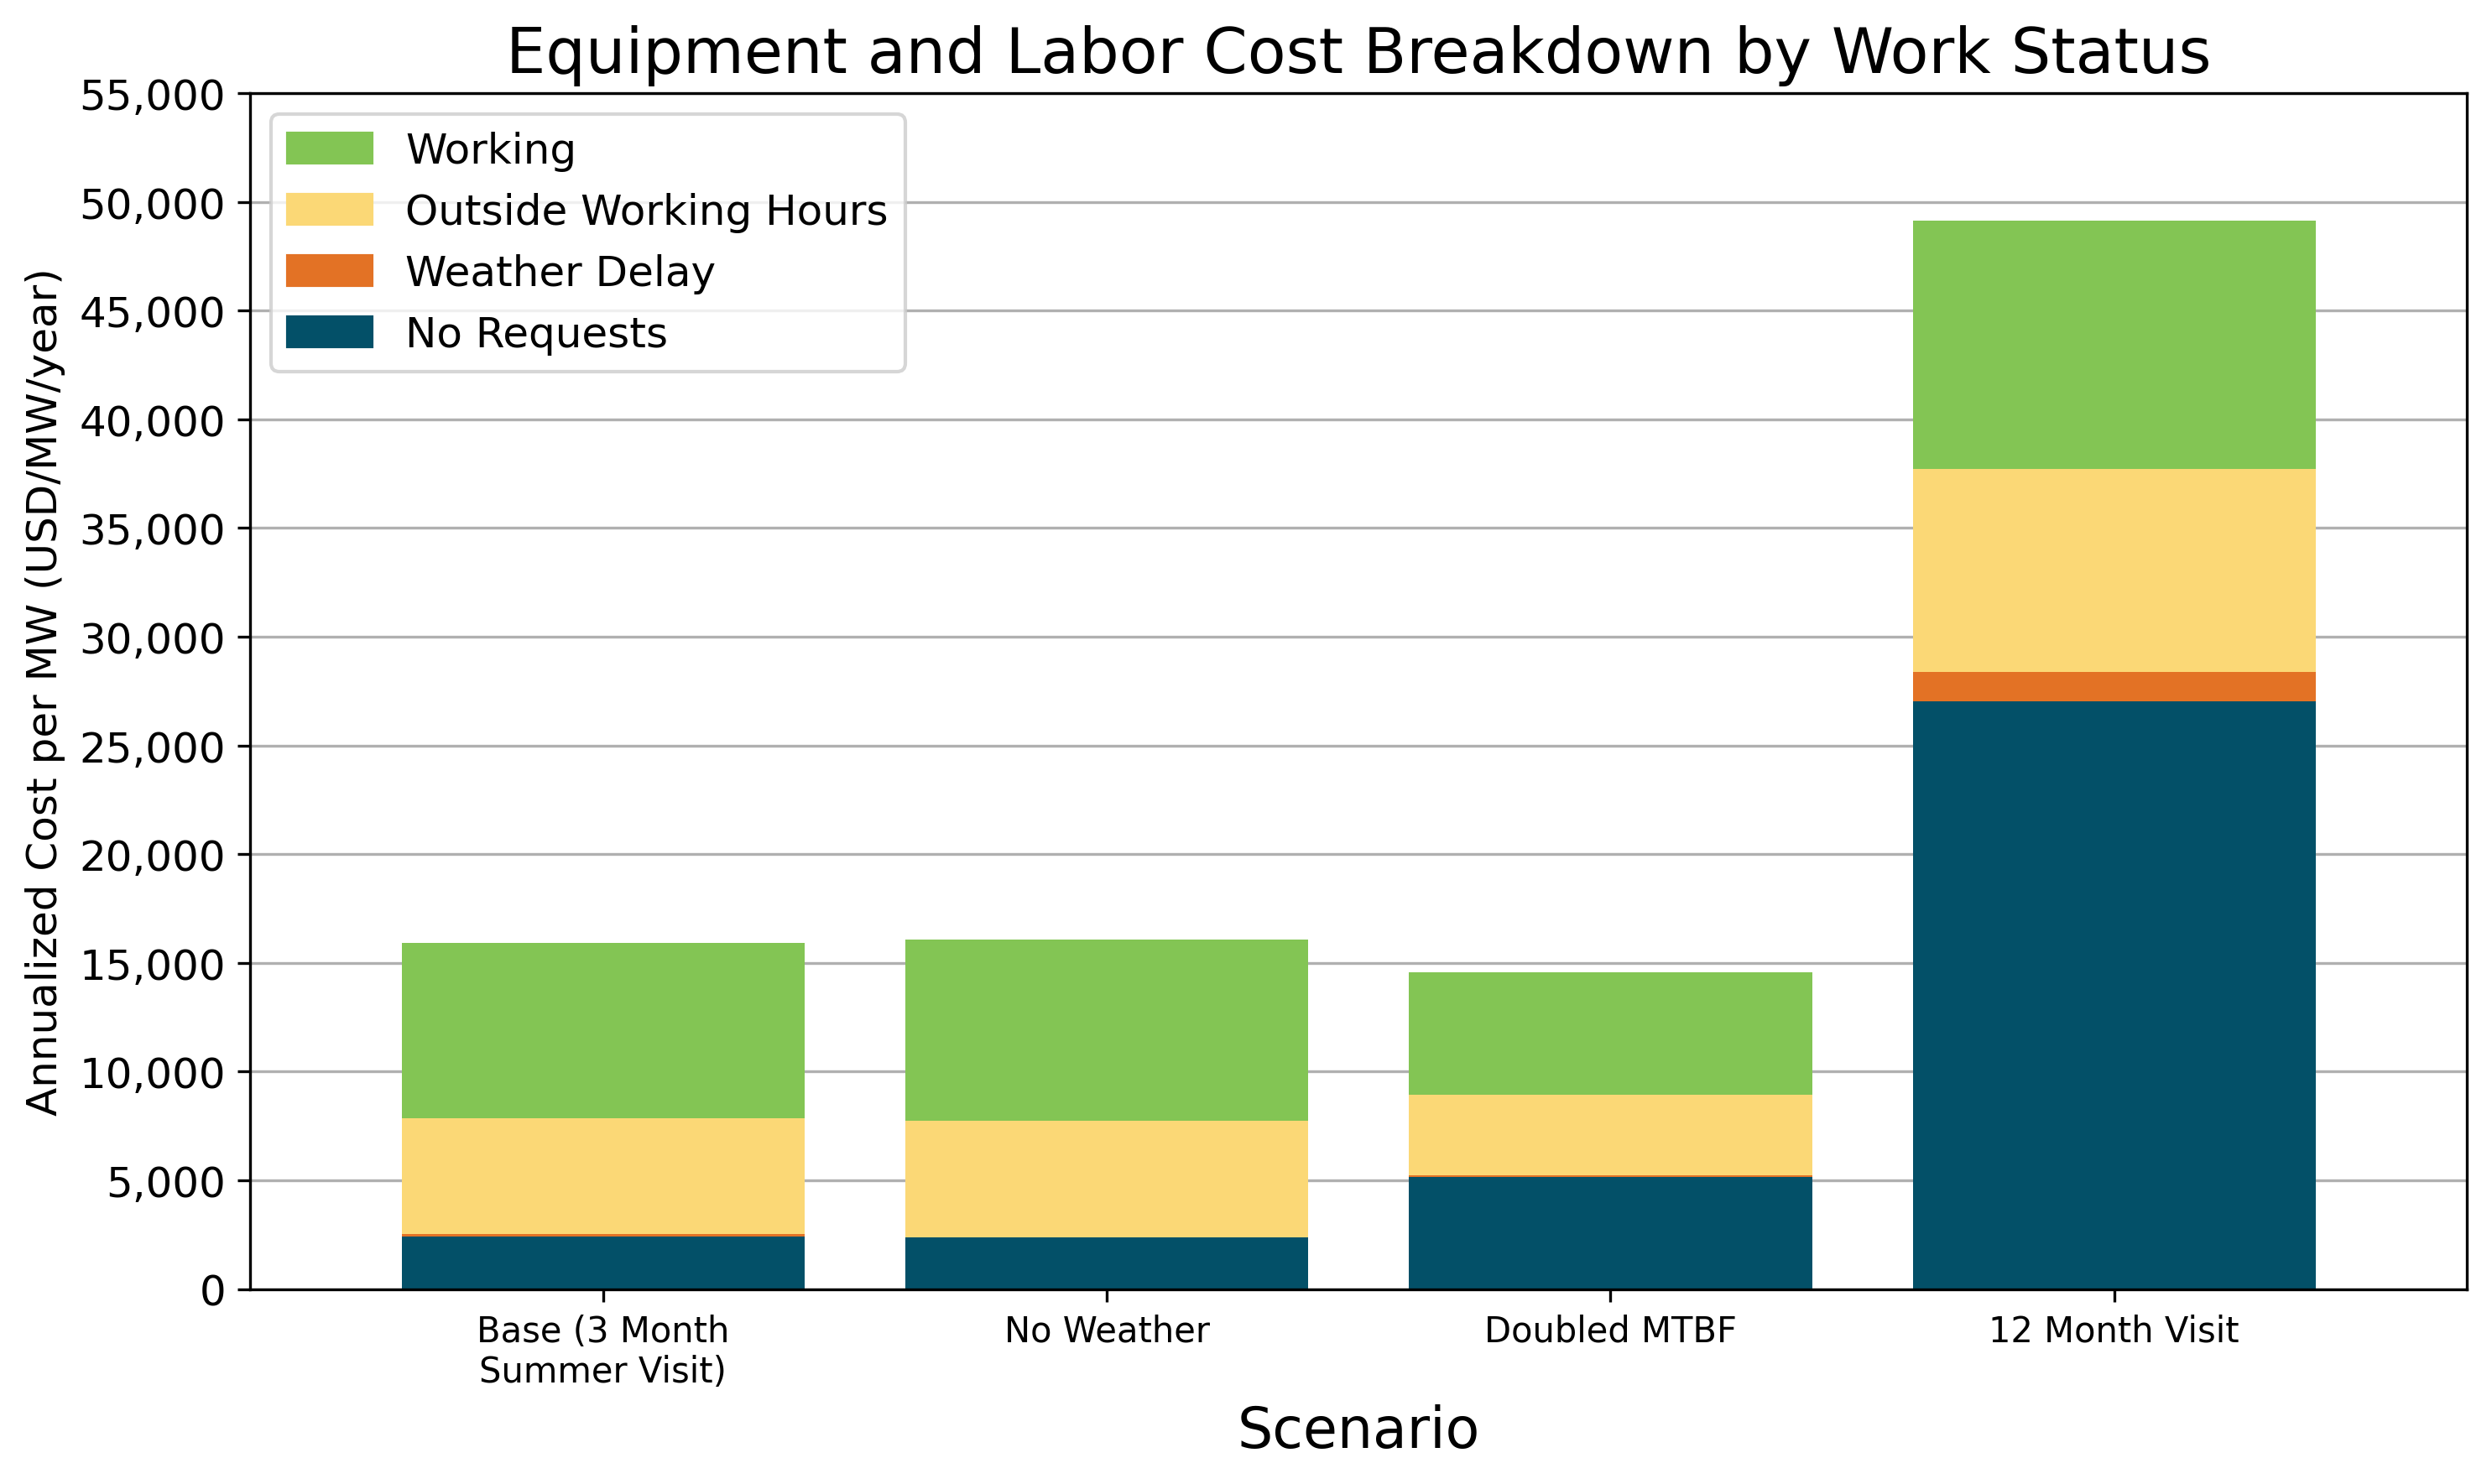

In [22]:
fig = plt.figure(figsize=(10, 6), dpi=300)
ax = fig.add_subplot(111)

colors = ["#035068", "#E37225", "#FBD876", "#83C554"]
indices = ["No Requests", "Weather Delay", "Outside Working Hours", "Working"]
_data_frames = {
    name: values for name, values in data_frames.items() if name.startswith("onshore")
}
x_tick_labels = [format_dict[s]["name"] for s in _data_frames]
y_ticks = range(0, 55001, 5000)

patches = []
for name, color in zip(indices, colors):
    patch = mpatches.Patch(color=color, label=name)
    patches.append(patch)

for i, scenario in enumerate(_data_frames):
    if all(s is None for s in scenarios[scenario][2:]):
        continue
    name = format_dict[scenario]["name"]
    events = data_frames[scenario]["events"]
    equip_labor = equipment_labor_cost_breakdown(
        events, onshore_equipment, onshore_total_mw, 20
    )

    bottom = 0
    for c, ix in zip(colors, indices):
        if ix not in equip_labor.index:
            continue
        ax.bar(i, equip_labor.loc[ix], bottom=bottom, color=c)
        bottom += equip_labor.loc[ix]

ax.set_xticks(range(len(x_tick_labels)))
ax.set_xticklabels(
    [make_label_multi_lines(x, longest_line_length=15) for x in x_tick_labels],
    fontsize=10,
)
ax.set_yticks(y_ticks)
ax.set_yticklabels([f"{y:,.0f}" for y in y_ticks], fontsize=12)

ax.set_title("Equipment and Labor Cost Breakdown by Work Status", fontsize=18)
ax.set_xlabel("Scenario", fontsize=16)
ax.set_ylabel("Annualized Cost per MW (USD/MW/year)", fontsize=12)

ax.set_xlim(-0.7, 3.7)
ax.set_ylim(0, 55000)
ax.legend(handles=list(reversed(patches)), ncol=1, fontsize=12, loc="upper left")

ax.grid(axis="y")
ax.set_axisbelow(True)

fig.tight_layout()
plt.savefig(
    os.path.join(
        library_path,
        "outputs/plots_and_tables/presentation/onshore_equipment_labor_breakdown.png",
    ),
    bbox_inches="tight",
)
plt.savefig(
    os.path.join(
        library_path,
        "outputs/plots_and_tables/presentation/onshore_equipment_labor_breakdown.svg",
    ),
    bbox_inches="tight",
)

## Onshore Cost vs Availability Comparison

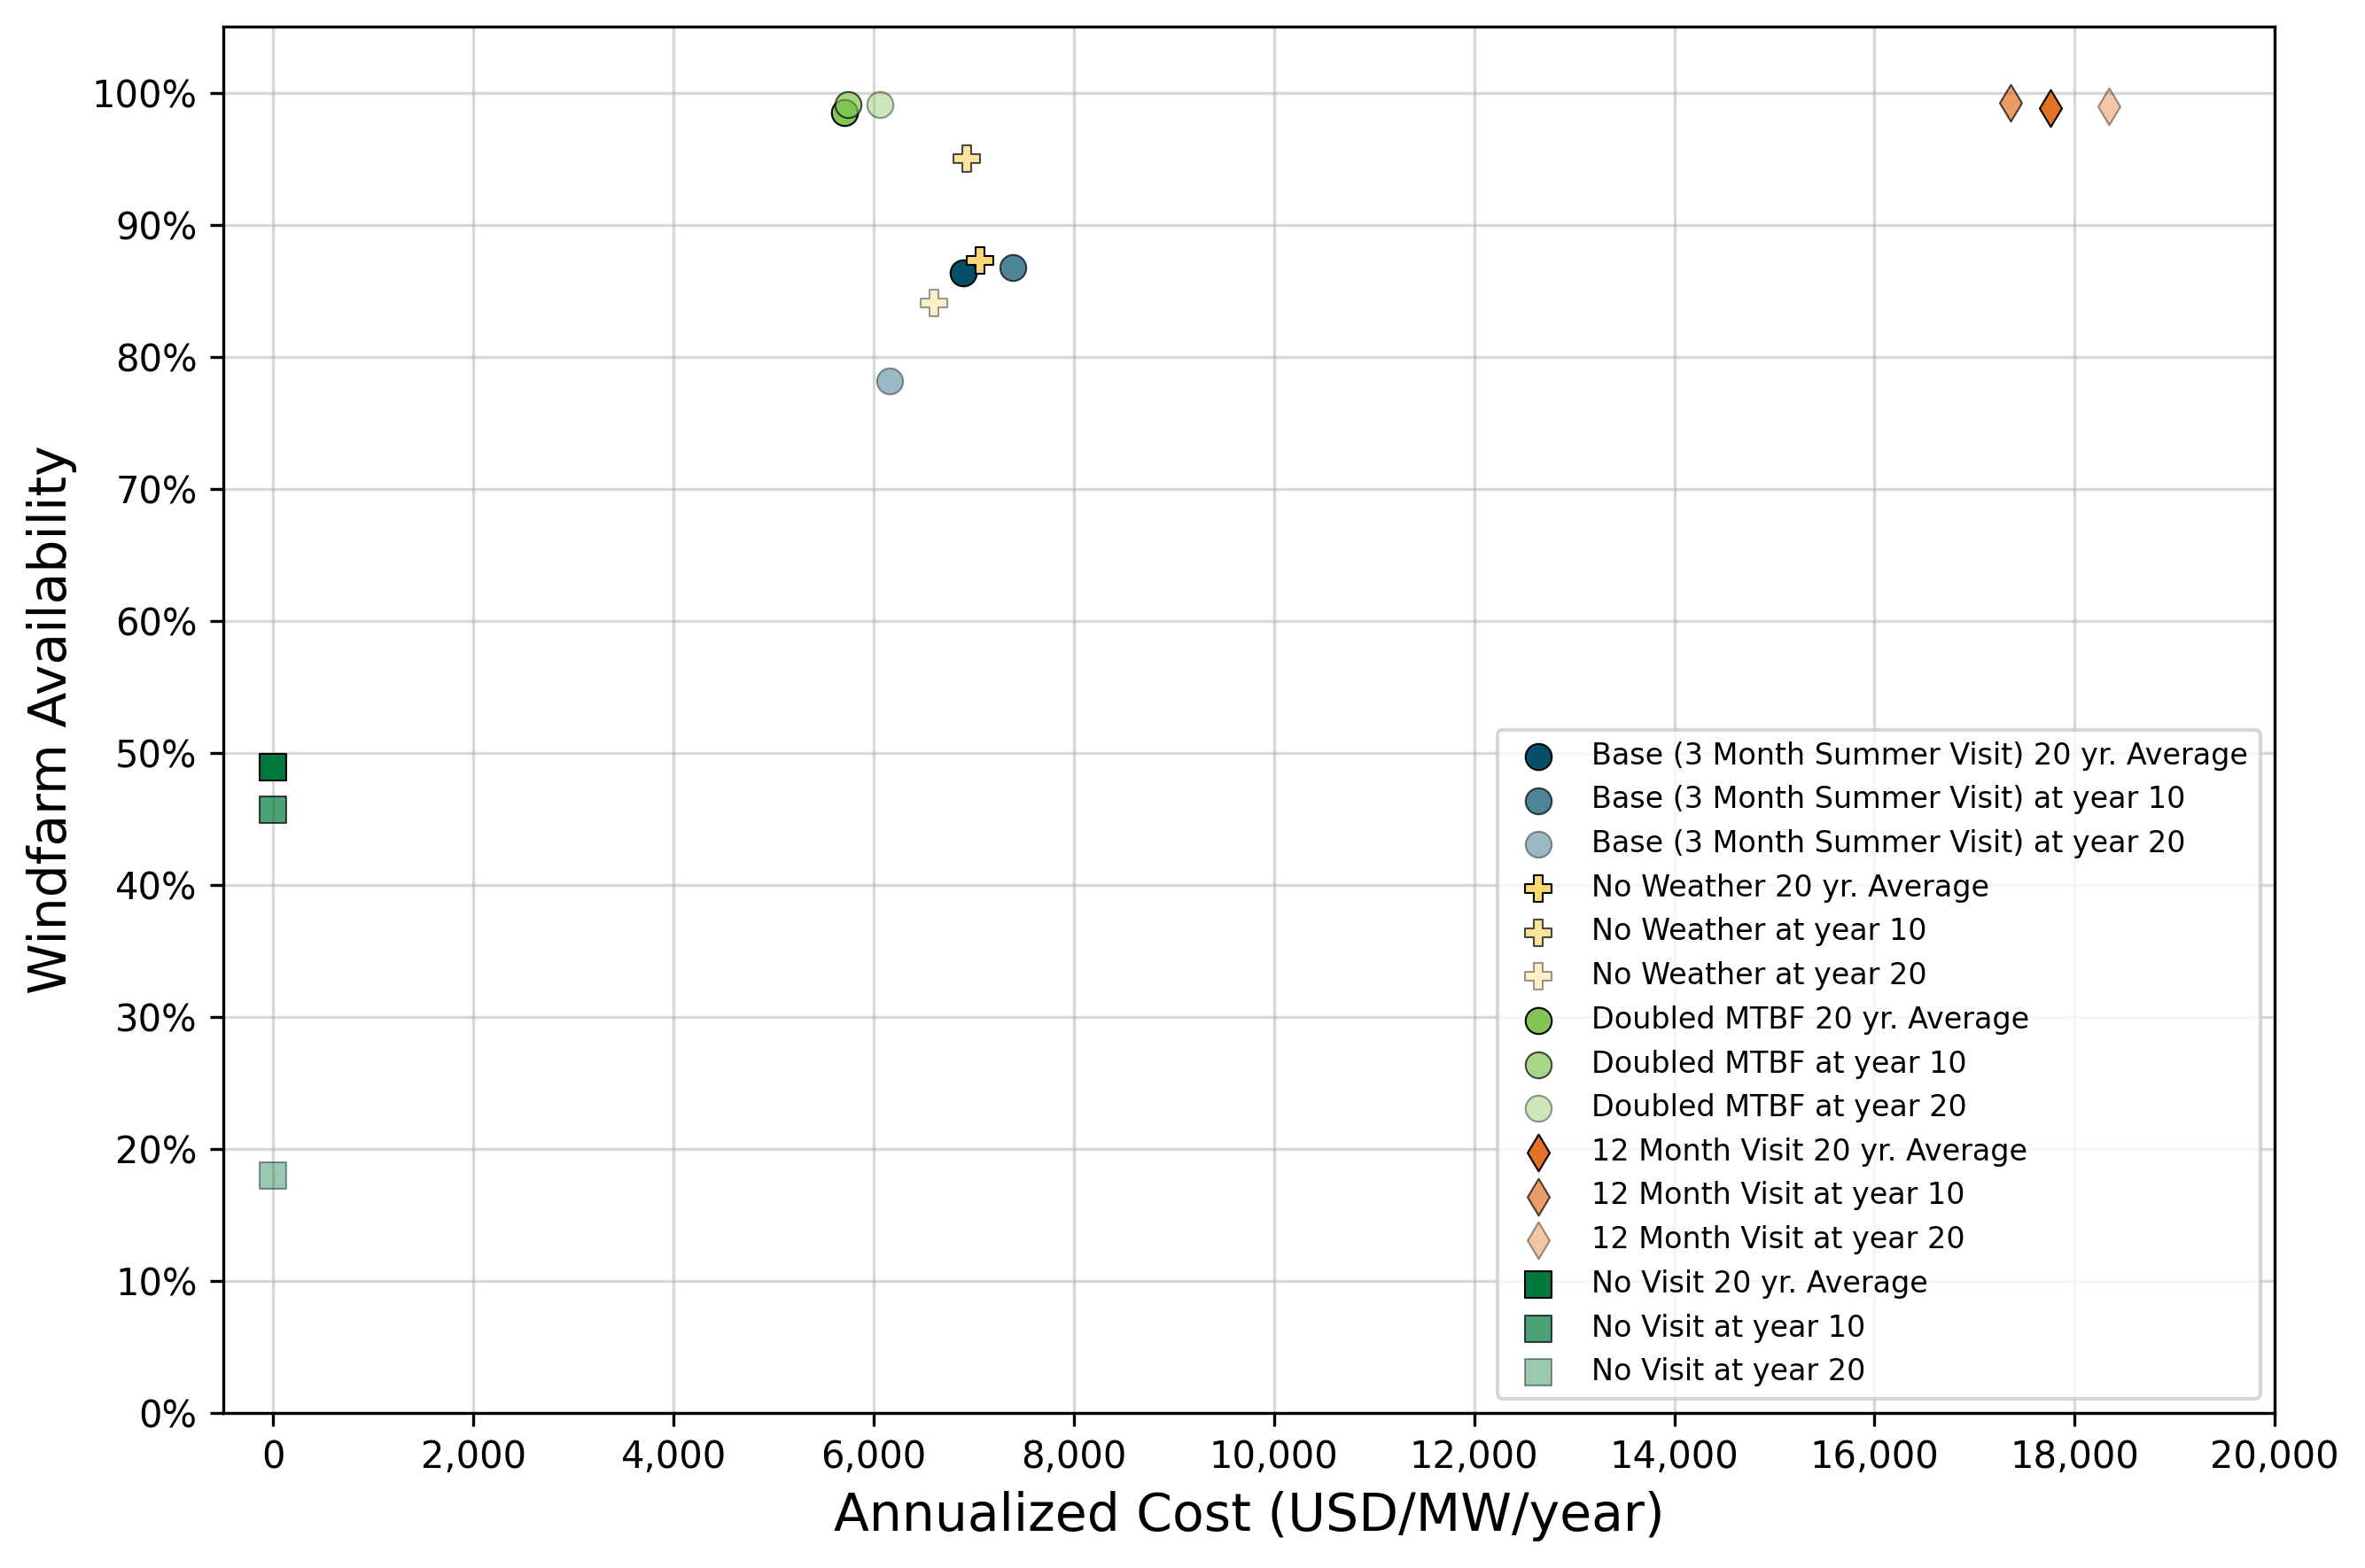

In [23]:
fig = plt.figure(figsize=(9, 6), dpi=300)
ax = fig.add_subplot(111)

x_ticks = range(0, 20001, 2000)
ax.set_xticks(x_ticks)
ax.set_xticklabels([f"{x:,.0f}" for x in x_ticks])

y_ticks = range(0, 101, 10)
ax.set_yticks(y_ticks)
ax.set_yticklabels([f"{y:.0f}%" for y in y_ticks])

ax.grid(alpha=0.5)
ax.set_axisbelow(True)

ax.set_xlim(-500, 20000)
ax.set_ylim(0, 105)

ax.set_xlabel("Annualized Cost (USD/MW/year)", fontsize=14)
ax.set_ylabel("Windfarm Availability", fontsize=14)

arrow_props = arrowprops = dict(arrowstyle="-", linewidth=0.5, zorder=0)

_data_frames = {
    name: values for name, values in data_frames.items() if name.startswith("onshore")
}
for scenario in _data_frames:
    name = format_dict[scenario]["name"]
    events = data_frames[scenario]["events"]
    fmt = format_dict[scenario]["format"]

    costs = data_frames[scenario]["events"][["year", "total_cost"]]
    costs = [
        costs[costs.year == 2007].total_cost.sum(),
        costs[costs.year == 2017].total_cost.sum(),
    ]
    costs = [
        data_frames[scenario]["events"].total_cost.sum()
        / offshore_total_mw
        / len(years)
    ] + [el / offshore_total_mw for el in costs]

    availability = data_frames[scenario]["operations"]
    availability = [
        get_availability_data(availability[availability.year == 2007])[1],
        get_availability_data(availability[availability.year == 2017])[1],
    ]
    availability = [data_frames[scenario]["project_availability"] * 100] + [
        el * 100 for el in availability
    ]

    ax.scatter(
        costs[0],
        availability[0],
        s=50,
        color=fmt["marker_color"],
        marker=fmt["marker"],
        edgecolor="black",
        linewidth=0.5,
        label=f"{name} 20 yr. Average",
    )
    ax.scatter(
        costs[1],
        availability[1],
        s=50,
        color=fmt["marker_color"],
        marker=fmt["marker"],
        alpha=0.7,
        edgecolor="black",
        linewidth=0.5,
        label=f"{name} at year 10",
    )
    ax.scatter(
        costs[2],
        availability[2],
        s=50,
        color=fmt["marker_color"],
        marker=fmt["marker"],
        alpha=0.4,
        edgecolor="black",
        linewidth=0.5,
        label=f"{name} at year 20",
    )

ax.legend(loc="lower right", fontsize=8)

fig.tight_layout()
plt.savefig(
    os.path.join(
        library_path,
        "outputs/plots_and_tables/presentation/onshore_cost_availability.png",
    ),
    bbox_to_inches="tight",
)
plt.savefig(
    os.path.join(
        library_path,
        "outputs/plots_and_tables/presentation/onshore_cost_availability.svg",
    ),
    bbox_to_inches="tight",
)